Combining VAE and GAN for our stl files. Below codes are mainly based on https://github.com/Spartey/3D-VAE-GAN-Deep-Learning-Project/tree/master/3D-VAE-WGAN

Our input is mesh format, 1 dimensional (reshaped) or 2 dimensional (matrix for triangles) not 3 dimenional as in the reference code.

**Issues/Questions:**

1. use tanh not relu for stl file?

### Environment Setup

In [1]:
import os, time, itertools
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(0)
tf.set_random_seed(0)

### Import Data

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl
from data.stl import plot_mesh

thingi = Thingi10k.init10()
n_samples = len(thingi)
n_samples

10

In [3]:
# preprocessing... making sure the voxels are available
for batch in thingi.voxels_batchmaker(10):
    break


for item in batch:
    print(item.shape)


(256, 256, 256, 1)
(256, 256, 256, 1)
(256, 256, 256, 1)
(256, 256, 256, 1)
(256, 256, 256, 1)
(256, 256, 256, 1)
(256, 256, 256, 1)
(256, 256, 256, 1)
(256, 256, 256, 1)
(256, 256, 256, 1)


### Configuration

In [4]:
D_lr = 5e-5
G_lr = 1e-4
n_latent = 50
alpha_1 = 5  ### weight for VAE loss function, KL Divergence loss
alpha_2 = 5e-4 ### weight for VAE loss function, reconstruction loss

output_dir = os.path.join('_output', '3d-vae-gan')
os.makedirs(output_dir, exist_ok=True)
graphs_dir = os.path.join(output_dir, 'graphs')
os.makedirs(graphs_dir, exist_ok=True)
model_dir = os.path.join(output_dir, 'model')
os.makedirs(model_dir, exist_ok=True)

### Models

In [5]:
def encoder(x, keep_prob=0.5, isTrain=True):
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
        # original architecture started with images as input thus used as conv2d for 2d data
        # we are using 3d inputs via voxels
        # so here we reuse the layers from the discriminator with small modifications because we
        # are going in and not out

        #conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same',
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu1 = tf.nn.elu(conv1)

        #conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same',
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=isTrain))

        #conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same',
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=isTrain))

        #conv4 = tf.layers.conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same',
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=isTrain))

        #conv5 = tf.layers.conv2d(lrelu4, 32, [4, 4], strides=(1, 1), padding='valid',
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv5, training=isTrain))

        conv1 = tf.layers.conv3d(x, 128, [4, 4, 4], strides=(2, 2, 2), padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.nn.elu(conv1)
        
        conv2 = tf.layers.conv3d(lrelu1, 256, [4, 4, 4], strides=(2, 2, 2), padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=isTrain))

        #conv3 = tf.layers.conv3d(lrelu2, 512, [4, 4, 4], strides=(2, 2, 2), padding='same',
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=isTrain))

        #conv4 = tf.layers.conv3d(lrelu3, 1024, [4, 4, 4], strides=(2, 2, 2), padding='same',
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=isTrain))

        #conv5 = tf.layers.conv3d(lrelu4, 32, [4, 4, 4], strides=(1, 1, 1), padding='valid',
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv5 = tf.layers.conv3d(lrelu2, 32, [4, 4, 4], strides=(1, 1, 1), padding='valid',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        #o = tf.nn.sigmoid(conv4)
        lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv5, training=isTrain))

        x = tf.nn.dropout(lrelu5, keep_prob)
        x = tf.contrib.layers.flatten(x)
        z_mu = tf.layers.dense(x, units=n_latent)
        z_sig = 0.5 * tf.layers.dense(x, units=n_latent)
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent]))
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))

        print("conv1 shape: ",conv1.shape)
        print("lrelu1 shape: ",lrelu1.shape)
        print("conv2 shape: ",conv2.shape)
        print("lrelu2 shape: ",lrelu2.shape)
        #print("conv3 shape: ",conv3.shape)
        #print("lrelu3 shape: ",lrelu3.shape)
        #print("conv4 shape: ",conv4.shape)
        #print("lrelu4 shape: ",lrelu4.shape)
        print("conv5 shape: ",conv5.shape)
        print("lrelu5 shape: ",lrelu5.shape)
        print("x shape: ", x.shape)
        print("z_mu shape: ", z_mu.shape)
        print("z_sig shape:", z_sig.shape)
        print("eps shape: ", epsilon.shape)
        print("z shape: ", z.shape)

        return z, z_mu, z_sig

def generator(x, isTrain=True):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):

        # 1st hidden layer
        conv1 = tf.layers.conv3d_transpose(x, 256, [4, 4, 4], strides=(1, 1, 1), padding='valid', use_bias=False,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=isTrain))

        # 2nd hidden layer
        #conv2 = tf.layers.conv3d_transpose(lrelu1, 128, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
        #                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=isTrain))

        # 3rd hidden layer
        #conv3 = tf.layers.conv3d_transpose(lrelu2, 64, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
        #                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=isTrain))

        # 4th hidden layer
        #conv4 = tf.layers.conv3d_transpose(lrelu3, 32, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
        #                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv4 = tf.layers.conv3d_transpose(lrelu1, 32, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=isTrain))

        # output layer
        conv5 = tf.layers.conv3d_transpose(lrelu4, 1, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        o = tf.nn.tanh(conv5)

        return o


def discriminator(x, isTrain=True):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):

        # 1st hidden layer
        conv1 = tf.layers.conv3d(x, 128, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.nn.elu(conv1)
        
        # 2nd hidden layer
        #conv2 = tf.layers.conv3d(lrelu1, 256, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=isTrain))

        # 3rd hidden layer
        #conv3 = tf.layers.conv3d(lrelu2, 512, [4, 4, 4], strides=(2, 2, 2), padding='same', use_bias=False,
        #                         kernel_initializer=tf.contrib.layers.xavier_initializer())
        #lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=isTrain))

        # output layer
        #conv4 = tf.layers.conv3d(lrelu3, 1, [4, 4, 4], strides=(1, 1, 1), padding='valid', use_bias=False,
        #                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv4 = tf.layers.conv3d(lrelu1, 1, [4, 4, 4], strides=(1, 1, 1), padding='valid', use_bias=False,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        o = tf.nn.sigmoid(conv4)

        return o, conv4

    
# variables : input
#x_image = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
x_encoder_in = tf.placeholder(tf.float32, shape=(None, 256, 256, 256, 1))
#x_3D = tf.placeholder(tf.float32, shape=(None, 32, 32, 32, 1))
x_discr_in = tf.placeholder(tf.float32, shape=(None, 256, 256, 256, 1))

keep_prob = tf.placeholder(dtype=tf.float32)
isTrain = tf.placeholder(dtype=tf.bool)

# networks : encoder
z, z_mu, z_sig = encoder(x_encoder_in, keep_prob, isTrain)
z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
# networks : generator
G_z = generator(z, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x_discr_in, isTrain)
D_fake, D_fake_logits = discriminator(G_z, isTrain)

# loss for each network

reconstruction_loss = tf.reduce_sum(tf.squared_difference(tf.reshape(G_z, (-1, 4096)),
                                                          tf.reshape(x_discr_in, (-1, 4096))),
                                    1)
KL_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)
mean_KL = tf.reduce_sum(KL_divergence)
mean_recon = tf.reduce_sum(reconstruction_loss)

VAE_loss = tf.reduce_mean(alpha_1 * KL_divergence + alpha_2 * reconstruction_loss)


D_loss_real = tf.reduce_mean(D_real_logits)
D_loss_fake = tf.reduce_mean(D_fake_logits)
D_loss = D_loss_real - D_loss_fake
G_loss = -tf.reduce_mean(D_fake_logits)
# sub_loss = G_loss + VAE_loss

print(tf.summary.scalar('D_loss', D_loss))
print(tf.summary.scalar('G_loss', G_loss))

conv1 shape:  (?, 128, 128, 128, 128)
lrelu1 shape:  (?, 128, 128, 128, 128)
conv2 shape:  (?, 64, 64, 64, 256)
lrelu2 shape:  (?, 64, 64, 64, 256)
conv5 shape:  (?, 61, 61, 61, 32)
lrelu5 shape:  (?, 61, 61, 61, 32)
x shape:  (?, 7263392)
z_mu shape:  (?, 50)
z_sig shape: (?, 50)
eps shape:  (?, 50)
z shape:  (?, 50)
Tensor("D_loss:0", shape=(), dtype=string)
Tensor("G_loss:0", shape=(), dtype=string)


In [6]:
# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]
E_vars = [var for var in T_vars if var.name.startswith('encoder')]

clip = [p.assign(tf.clip_by_value(p, -0.5, 0.5)) for p in D_vars]

# optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.RMSPropOptimizer(D_lr).minimize(-D_loss, var_list=D_vars)
    G_optim = tf.train.RMSPropOptimizer(G_lr).minimize(G_loss, var_list=G_vars)
    E_optim = tf.train.AdamOptimizer(G_lr).minimize(VAE_loss, var_list=E_vars)
    # E_optim = tf.train.RMSPropOptimizer(lr).minimize(VAE_loss, var_list=E_vars)
    
print('\nReady for training!')


Ready for training!


Start Training
	num_epochs =  100
	batch_size =  1
	save_every =  10
Epoch 0 Start
	Batch=0
###########
epoch:
D Loss: -0.0042405818
G Loss: -0.004189302
VAE loss: 167.07806
KL divergence: 33.36974
reconstruction_loss: 1878367.2


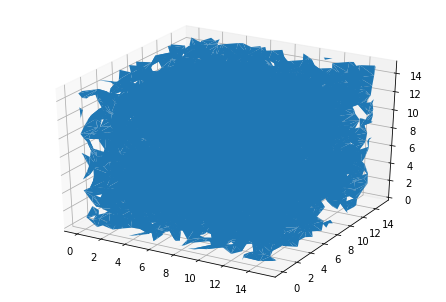

Model saved at _output/3d-vae-gan/model/epoch_0/model.ckpt
###########
Epoch 0 Completed
Elapsed Time: 0.8748453656832377 mins
Epoch 1 Start
	Batch=0
Epoch 1 Completed
Elapsed Time: 1.3279608845710755 mins
Epoch 2 Start
	Batch=0
Epoch 2 Completed
Elapsed Time: 1.7827521920204163 mins
Epoch 3 Start
	Batch=0
Epoch 3 Completed
Elapsed Time: 2.2372230569521587 mins
Epoch 4 Start
	Batch=0
Epoch 4 Completed
Elapsed Time: 2.6943630735079447 mins
Epoch 5 Start
	Batch=0
Epoch 5 Completed
Elapsed Time: 3.1487432678540546 mins
Epoch 6 Start
	Batch=0
Epoch 6 Completed
Elapsed Time: 3.605887997150421 mins
Epoch 7 Start
	Batch=0
Epoch 7 Completed
Elapsed Time: 4.060602903366089 mins
Epoch 8 Start
	Batch=0
Epoch 8 Completed
Elapsed Time: 4.514752840995788 mins
Epoch 9 Start
	Batch=0
Epoch 9 Completed
Elapsed Time: 4.965309035778046 mins
Epoch 10 Start
	Batch=0
###########
epoch:
D Loss: 0.0007957162
G Loss: 0.00083588937
VAE loss: 21263.906
KL divergence: 4252.707
reconstruction_loss: 1863483.4


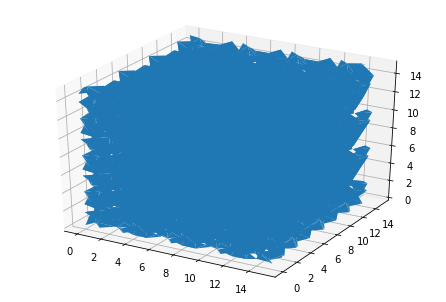

Model saved at _output/3d-vae-gan/model/epoch_10/model.ckpt
###########
Epoch 10 Completed
Elapsed Time: 5.8197771867116295 mins
Epoch 11 Start
	Batch=0
Epoch 11 Completed
Elapsed Time: 6.267930662631988 mins
Epoch 12 Start
	Batch=0
Epoch 12 Completed
Elapsed Time: 6.716455864906311 mins
Epoch 13 Start
	Batch=0
Epoch 17 Completed
Elapsed Time: 8.962468524773916 mins
Epoch 18 Start
	Batch=0
Epoch 18 Completed
Elapsed Time: 9.413504509131114 mins
Epoch 19 Start
	Batch=0
Epoch 19 Completed
Elapsed Time: 9.864856656392416 mins
Epoch 20 Start
	Batch=0
###########
epoch:
D Loss: 0.00538647
G Loss: 0.0053857397
VAE loss: 10232.006
KL divergence: 2046.3596
reconstruction_loss: 1888593.0


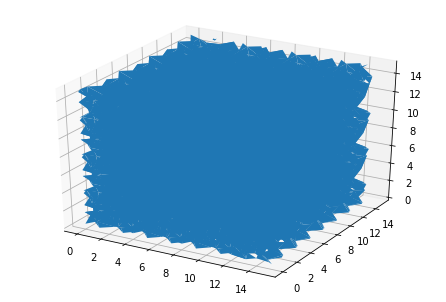

Model saved at _output/3d-vae-gan/model/epoch_20/model.ckpt
###########
Epoch 20 Completed
Elapsed Time: 10.719877556959789 mins
Epoch 21 Start
	Batch=0
Epoch 21 Completed
Elapsed Time: 11.16556956768036 mins
Epoch 22 Start
	Batch=0
Epoch 22 Completed
Elapsed Time: 11.61129752000173 mins
Epoch 23 Start
	Batch=0
Epoch 23 Completed
Elapsed Time: 12.054177316029866 mins
Epoch 24 Start
	Batch=0
Epoch 24 Completed
Elapsed Time: 12.502682558695476 mins
Epoch 25 Start
	Batch=0
Epoch 25 Completed
Elapsed Time: 12.946355644861857 mins
Epoch 26 Start
	Batch=0
Epoch 26 Completed
Elapsed Time: 13.401244723796845 mins
Epoch 27 Start
	Batch=0
Epoch 27 Completed
Elapsed Time: 13.846781706809997 mins
Epoch 28 Start
	Batch=0
Epoch 28 Completed
Elapsed Time: 14.291795027256011 mins
Epoch 29 Start
	Batch=0
Epoch 29 Completed
Elapsed Time: 14.742248253027599 mins
Epoch 30 Start
	Batch=0
###########
epoch:
D Loss: 0.03991396
G Loss: 0.03979597
VAE loss: 5470.76
KL divergence: 1094.1106
reconstruction_loss:

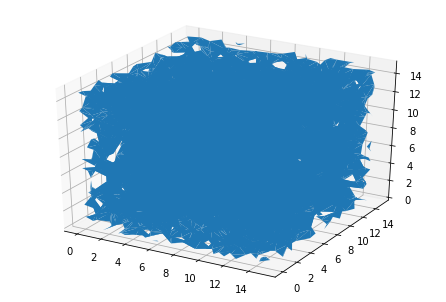

Model saved at _output/3d-vae-gan/model/epoch_30/model.ckpt
###########
Epoch 30 Completed
Elapsed Time: 15.598551758130391 mins
Epoch 31 Start
	Batch=0
Epoch 31 Completed
Elapsed Time: 16.05172746181488 mins
Epoch 32 Start
	Batch=0
Epoch 32 Completed
Elapsed Time: 16.501667133967082 mins
Epoch 33 Start
	Batch=0
Epoch 33 Completed
Elapsed Time: 16.952592754364012 mins
Epoch 34 Start
	Batch=0
Epoch 34 Completed
Elapsed Time: 17.403076040744782 mins
Epoch 35 Start
	Batch=0
Epoch 35 Completed
Elapsed Time: 17.85423276424408 mins
Epoch 36 Start
	Batch=0
Epoch 36 Completed
Elapsed Time: 18.30192037820816 mins
Epoch 37 Start
	Batch=0
Epoch 37 Completed
Elapsed Time: 18.751430507500967 mins
Epoch 38 Start
	Batch=0
Epoch 38 Completed
Elapsed Time: 19.197270226478576 mins
Epoch 39 Start
	Batch=0
Epoch 39 Completed
Elapsed Time: 19.64483114480972 mins
Epoch 40 Start
	Batch=0
###########
epoch:
D Loss: 0.12352465
G Loss: 0.123113416
VAE loss: 3276.2527
KL divergence: 655.2041
reconstruction_loss:

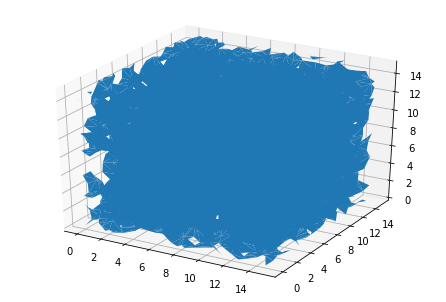

Model saved at _output/3d-vae-gan/model/epoch_40/model.ckpt
###########
Epoch 40 Completed
Elapsed Time: 20.269597987333935 mins
Epoch 41 Start
	Batch=0
Epoch 41 Completed
Elapsed Time: 20.715220483144126 mins
Epoch 42 Start
	Batch=0
Epoch 42 Completed
Elapsed Time: 21.16783128976822 mins
Epoch 43 Start
	Batch=0
Epoch 43 Completed
Elapsed Time: 21.61650156180064 mins
Epoch 44 Start
	Batch=0
Epoch 44 Completed
Elapsed Time: 22.065578349431355 mins
Epoch 45 Start
	Batch=0
Epoch 45 Completed
Elapsed Time: 22.518588932355247 mins
Epoch 46 Start
	Batch=0
Epoch 46 Completed
Elapsed Time: 22.972144269943236 mins
Epoch 47 Start
	Batch=0
Epoch 47 Completed
Elapsed Time: 23.42381615638733 mins
Epoch 48 Start
	Batch=0
Epoch 48 Completed
Elapsed Time: 23.872971924146018 mins
Epoch 49 Start
	Batch=0
Epoch 49 Completed
Elapsed Time: 24.32425111134847 mins
Epoch 50 Start
	Batch=0
###########
epoch:
D Loss: 0.21375617
G Loss: 0.21291095
VAE loss: 2837.245
KL divergence: 567.4028
reconstruction_loss: 1

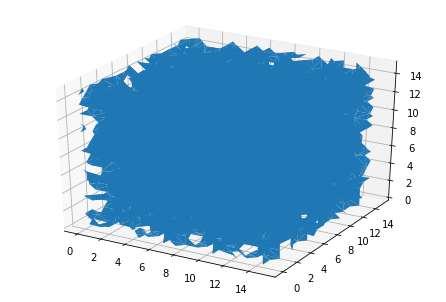

Model saved at _output/3d-vae-gan/model/epoch_50/model.ckpt
###########
Epoch 50 Completed
Elapsed Time: 24.952740077177683 mins
Epoch 51 Start
	Batch=0
Epoch 51 Completed
Elapsed Time: 25.400406356652578 mins
Epoch 52 Start
	Batch=0
Epoch 52 Completed
Elapsed Time: 25.854906010627747 mins
Epoch 53 Start
	Batch=0
Epoch 53 Completed
Elapsed Time: 26.30508999824524 mins
Epoch 54 Start
	Batch=0
Epoch 54 Completed
Elapsed Time: 26.757621256510415 mins
Epoch 55 Start
	Batch=0
Epoch 55 Completed
Elapsed Time: 27.21135872999827 mins
Epoch 56 Start
	Batch=0
Epoch 56 Completed
Elapsed Time: 27.658595832188926 mins
Epoch 57 Start
	Batch=0
Epoch 57 Completed
Elapsed Time: 28.108063141504925 mins
Epoch 58 Start
	Batch=0
Epoch 58 Completed
Elapsed Time: 28.556525921821596 mins
Epoch 59 Start
	Batch=0
Epoch 59 Completed
Elapsed Time: 29.008143095175424 mins
Epoch 60 Start
	Batch=0
###########
epoch:
D Loss: 0.1604244
G Loss: 0.15913954
VAE loss: 1920.837
KL divergence: 384.12476
reconstruction_loss:

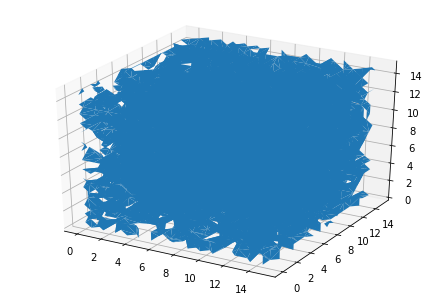

Model saved at _output/3d-vae-gan/model/epoch_60/model.ckpt
###########
Epoch 60 Completed
Elapsed Time: 29.63325829108556 mins
Epoch 61 Start
	Batch=0
Epoch 61 Completed
Elapsed Time: 30.0813263853391 mins
Epoch 62 Start
	Batch=0
Epoch 62 Completed
Elapsed Time: 30.52619260152181 mins
Epoch 63 Start
	Batch=0
Epoch 63 Completed
Elapsed Time: 30.97473838329315 mins
Epoch 64 Start
	Batch=0
Epoch 64 Completed
Elapsed Time: 31.424917805194855 mins
Epoch 65 Start
	Batch=0
Epoch 65 Completed
Elapsed Time: 31.872384802500406 mins
Epoch 66 Start
	Batch=0
Epoch 66 Completed
Elapsed Time: 32.31835099458694 mins
Epoch 67 Start
	Batch=0
Epoch 67 Completed
Elapsed Time: 32.7683450182279 mins
Epoch 68 Start
	Batch=0
Epoch 68 Completed
Elapsed Time: 33.212515298525496 mins
Epoch 69 Start
	Batch=0
Epoch 69 Completed
Elapsed Time: 33.65760858853658 mins
Epoch 70 Start
	Batch=0
###########
epoch:
D Loss: -0.008960063
G Loss: -0.009695483
VAE loss: 2326.0962
KL divergence: 465.17538
reconstruction_loss: 

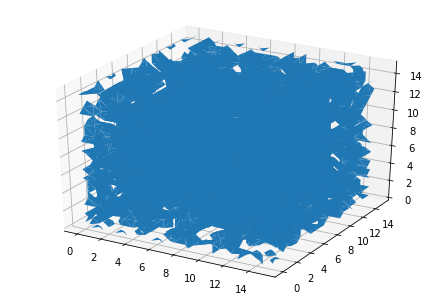

Model saved at _output/3d-vae-gan/model/epoch_70/model.ckpt
###########
Epoch 70 Completed
Elapsed Time: 34.27451674143473 mins
Epoch 71 Start
	Batch=0
Epoch 71 Completed
Elapsed Time: 34.723024129867554 mins
Epoch 72 Start
	Batch=0
Epoch 72 Completed
Elapsed Time: 35.172798371315004 mins
Epoch 73 Start
	Batch=0
Epoch 73 Completed
Elapsed Time: 35.62258326212565 mins
Epoch 74 Start
	Batch=0
Epoch 74 Completed
Elapsed Time: 36.071959344546 mins
Epoch 75 Start
	Batch=0
Epoch 75 Completed
Elapsed Time: 36.52494748433431 mins
Epoch 76 Start
	Batch=0
Epoch 76 Completed
Elapsed Time: 36.97423779964447 mins
Epoch 77 Start
	Batch=0
Epoch 77 Completed
Elapsed Time: 37.427257323265074 mins
Epoch 78 Start
	Batch=0
Epoch 78 Completed
Elapsed Time: 37.87315189043681 mins
Epoch 79 Start
	Batch=0
Epoch 79 Completed
Elapsed Time: 38.32773377895355 mins
Epoch 80 Start
	Batch=0
###########
epoch:
D Loss: -0.09963699
G Loss: -0.09885617
VAE loss: 2554.4346
KL divergence: 510.84357
reconstruction_loss: 18

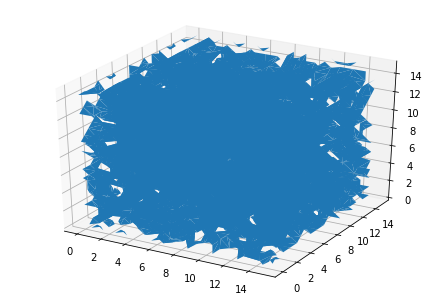

Model saved at _output/3d-vae-gan/model/epoch_80/model.ckpt
###########
Epoch 80 Completed
Elapsed Time: 38.95194404919942 mins
Epoch 81 Start
	Batch=0
Epoch 81 Completed
Elapsed Time: 39.4016641775767 mins
Epoch 82 Start
	Batch=0
Epoch 82 Completed
Elapsed Time: 39.85025064150492 mins
Epoch 83 Start
	Batch=0
Epoch 83 Completed
Elapsed Time: 40.30017229715983 mins
Epoch 84 Start
	Batch=0
Epoch 84 Completed
Elapsed Time: 40.752506124973294 mins
Epoch 85 Start
	Batch=0
Epoch 85 Completed
Elapsed Time: 41.20315406719843 mins
Epoch 86 Start
	Batch=0
Epoch 86 Completed
Elapsed Time: 41.65523119767507 mins
Epoch 87 Start
	Batch=0
Epoch 87 Completed
Elapsed Time: 42.10758885542552 mins
Epoch 88 Start
	Batch=0
Epoch 88 Completed
Elapsed Time: 42.55729104677836 mins
Epoch 89 Start
	Batch=0
Epoch 89 Completed
Elapsed Time: 43.0118170261383 mins
Epoch 90 Start
	Batch=0
###########
epoch:
D Loss: -0.06733329
G Loss: -0.06590002
VAE loss: 2571.8318
KL divergence: 514.32056
reconstruction_loss: 1821

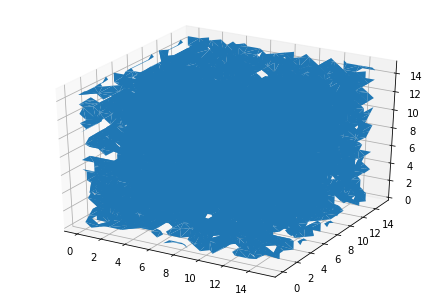

Model saved at _output/3d-vae-gan/model/epoch_90/model.ckpt
###########
Epoch 90 Completed
Elapsed Time: 43.63890908161799 mins
Epoch 91 Start
	Batch=0
Epoch 91 Completed
Elapsed Time: 44.086117653052014 mins
Epoch 92 Start
	Batch=0
Epoch 92 Completed
Elapsed Time: 44.53916932344437 mins
Epoch 93 Start
	Batch=0
Epoch 93 Completed
Elapsed Time: 44.989283796151476 mins
Epoch 94 Start
	Batch=0
Epoch 94 Completed
Elapsed Time: 45.43760087092718 mins
Epoch 95 Start
	Batch=0
Epoch 95 Completed
Elapsed Time: 45.88652896086375 mins
Epoch 96 Start
	Batch=0
Epoch 96 Completed
Elapsed Time: 46.336277914047244 mins
Epoch 97 Start
	Batch=0
Epoch 97 Completed
Elapsed Time: 46.78508606354396 mins
Epoch 98 Start
	Batch=0
Epoch 98 Completed
Elapsed Time: 47.234126687049866 mins
Epoch 99 Start
	Batch=0
Epoch 99 Completed
Elapsed Time: 47.68084711631139 mins
Epoch 100 Start
	Batch=0
###########
epoch:
D Loss: 0.008946987
G Loss: 0.0107192565
VAE loss: 2650.6206
KL divergence: 530.07886
reconstruction_los

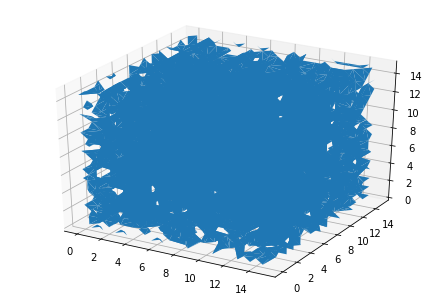

Model saved at _output/3d-vae-gan/model/epoch_100/model.ckpt
###########
Epoch 100 Completed
Elapsed Time: 48.30666057666143 mins
Epoch 101 Start
	Batch=0
Epoch 101 Completed
Elapsed Time: 48.75306001504262 mins
Epoch 102 Start
	Batch=0
Epoch 102 Completed
Elapsed Time: 49.201525096098585 mins
Epoch 103 Start
	Batch=0
Epoch 103 Completed
Elapsed Time: 49.651256612936656 mins
Epoch 104 Start
	Batch=0
Epoch 104 Completed
Elapsed Time: 50.10396968921025 mins
Epoch 105 Start
	Batch=0
Epoch 105 Completed
Elapsed Time: 50.55060379902522 mins
Epoch 106 Start
	Batch=0
Epoch 106 Completed
Elapsed Time: 50.99808911482493 mins
Epoch 107 Start
	Batch=0
Epoch 107 Completed
Elapsed Time: 51.45058170557022 mins
Epoch 108 Start
	Batch=0
Epoch 108 Completed
Elapsed Time: 51.8996742606163 mins
Epoch 109 Start
	Batch=0
Epoch 109 Completed
Elapsed Time: 52.349029052257535 mins
Epoch 110 Start
	Batch=0
###########
epoch:
D Loss: 0.030521132
G Loss: 0.0319893
VAE loss: 2397.3467
KL divergence: 479.42377
rec

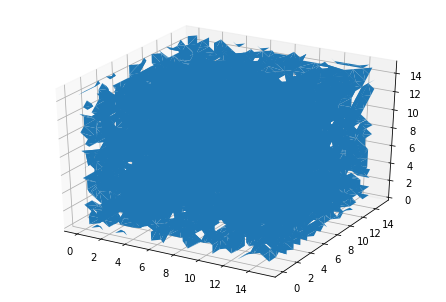

Model saved at _output/3d-vae-gan/model/epoch_110/model.ckpt
###########
Epoch 110 Completed
Elapsed Time: 52.97754491170247 mins
Epoch 111 Start
	Batch=0
Epoch 111 Completed
Elapsed Time: 53.42493545214335 mins
Epoch 112 Start
	Batch=0
Epoch 112 Completed
Elapsed Time: 53.875722992420194 mins
Epoch 113 Start
	Batch=0
Epoch 113 Completed
Elapsed Time: 54.32298933267593 mins
Epoch 114 Start
	Batch=0
Epoch 114 Completed
Elapsed Time: 54.77337530454 mins
Epoch 115 Start
	Batch=0
Epoch 115 Completed
Elapsed Time: 55.22314236164093 mins
Epoch 116 Start
	Batch=0
Epoch 116 Completed
Elapsed Time: 55.673954383532205 mins
Epoch 117 Start
	Batch=0
Epoch 117 Completed
Elapsed Time: 56.12354784806569 mins
Epoch 118 Start
	Batch=0
Epoch 118 Completed
Elapsed Time: 56.57188977003098 mins
Epoch 119 Start
	Batch=0
Epoch 119 Completed
Elapsed Time: 57.02241895198822 mins
Epoch 120 Start
	Batch=0
###########
epoch:
D Loss: 0.012107795
G Loss: 0.012706249
VAE loss: 2966.993
KL divergence: 593.35114
recon

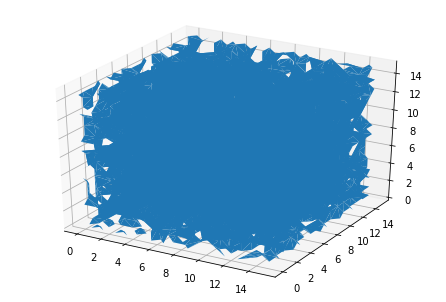

Model saved at _output/3d-vae-gan/model/epoch_120/model.ckpt
###########
Epoch 120 Completed
Elapsed Time: 57.64571667114894 mins
Epoch 121 Start
	Batch=0
Epoch 121 Completed
Elapsed Time: 58.096723504861195 mins
Epoch 122 Start
	Batch=0
Epoch 122 Completed
Elapsed Time: 58.54827312231064 mins
Epoch 123 Start
	Batch=0
Epoch 123 Completed
Elapsed Time: 59.000012191136676 mins
Epoch 124 Start
	Batch=0
Epoch 124 Completed
Elapsed Time: 59.45385975837708 mins
Epoch 125 Start
	Batch=0
Epoch 125 Completed
Elapsed Time: 59.90958413680394 mins
Epoch 126 Start
	Batch=0
Epoch 126 Completed
Elapsed Time: 60.35940086841583 mins
Epoch 127 Start
	Batch=0
Epoch 127 Completed
Elapsed Time: 60.81395387649536 mins
Epoch 128 Start
	Batch=0
Epoch 128 Completed
Elapsed Time: 61.26393426259359 mins
Epoch 129 Start
	Batch=0
Epoch 129 Completed
Elapsed Time: 61.71776487827301 mins
Epoch 130 Start
	Batch=0
###########
epoch:
D Loss: -0.022700425
G Loss: -0.023445258
VAE loss: 2982.2244
KL divergence: 596.39514

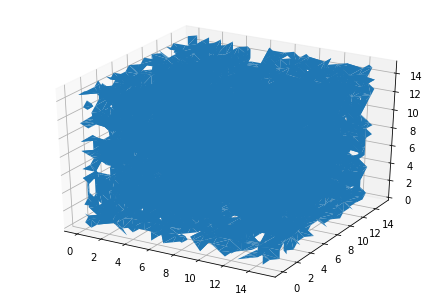

Model saved at _output/3d-vae-gan/model/epoch_130/model.ckpt
###########
Epoch 130 Completed
Elapsed Time: 62.34541464249293 mins
Epoch 131 Start
	Batch=0
Epoch 131 Completed
Elapsed Time: 62.793284865220386 mins
Epoch 132 Start
	Batch=0
Epoch 132 Completed
Elapsed Time: 63.24314274390539 mins
Epoch 133 Start
	Batch=0
Epoch 133 Completed
Elapsed Time: 63.69239404598872 mins
Epoch 134 Start
	Batch=0
Epoch 134 Completed
Elapsed Time: 64.14476268291473 mins
Epoch 135 Start
	Batch=0
###########
epoch:
D Loss: 0.020228311
G Loss: 0.018296076
VAE loss: 2425.1277
KL divergence: 484.97684
reconstruction_loss: 1979379.8


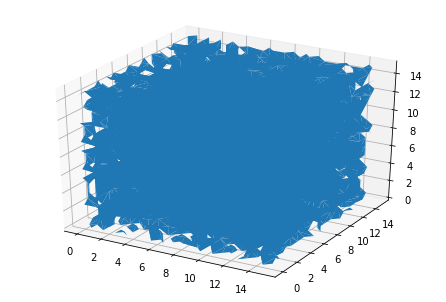

Model saved at _output/3d-vae-gan/model/epoch_140/model.ckpt
###########
Epoch 140 Completed
Elapsed Time: 67.03359877268473 mins
Epoch 141 Start
	Batch=0
Epoch 141 Completed
Elapsed Time: 67.4860965092977 mins
Epoch 142 Start
	Batch=0
Epoch 142 Completed
Elapsed Time: 67.93182809352875 mins
Epoch 143 Start
	Batch=0
Epoch 143 Completed
Elapsed Time: 68.38219558795294 mins
Epoch 144 Start
	Batch=0
Epoch 144 Completed
Elapsed Time: 68.83045874436696 mins
Epoch 145 Start
	Batch=0
Epoch 145 Completed
Elapsed Time: 69.27916022141774 mins
Epoch 146 Start
	Batch=0
Epoch 146 Completed
Elapsed Time: 69.73031170368195 mins
Epoch 147 Start
	Batch=0
Epoch 147 Completed
Elapsed Time: 70.17990607023239 mins
Epoch 148 Start
	Batch=0
Epoch 148 Completed
Elapsed Time: 70.62870603402456 mins
Epoch 149 Start
	Batch=0
Epoch 149 Completed
Elapsed Time: 71.07921974261602 mins
Epoch 150 Start
	Batch=0
###########
epoch:
D Loss: -0.02122218
G Loss: -0.022456301
VAE loss: 3051.8757
KL divergence: 610.3244
reco

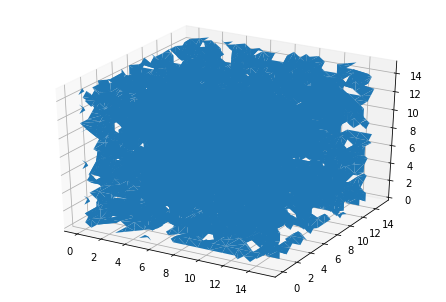

Model saved at _output/3d-vae-gan/model/epoch_150/model.ckpt
###########
Epoch 150 Completed
Elapsed Time: 71.70231496890386 mins
Epoch 151 Start
	Batch=0
Epoch 151 Completed
Elapsed Time: 72.15233960946401 mins
Epoch 152 Start
	Batch=0
Epoch 152 Completed
Elapsed Time: 72.6056533018748 mins
Epoch 153 Start
	Batch=0
Epoch 153 Completed
Elapsed Time: 73.05897258122762 mins
Epoch 154 Start
	Batch=0
Epoch 154 Completed
Elapsed Time: 73.5112554828326 mins
Epoch 155 Start
	Batch=0
Epoch 155 Completed
Elapsed Time: 73.9609235882759 mins
Epoch 156 Start
	Batch=0
Epoch 156 Completed
Elapsed Time: 74.41611834367116 mins
Epoch 157 Start
	Batch=0
Epoch 157 Completed
Elapsed Time: 74.8622973759969 mins
Epoch 158 Start
	Batch=0
Epoch 158 Completed
Elapsed Time: 75.31501321395238 mins
Epoch 159 Start
	Batch=0
Epoch 159 Completed
Elapsed Time: 75.76645409266153 mins
Epoch 160 Start
	Batch=0
###########
epoch:
D Loss: 0.00184747
G Loss: 0.002628931
VAE loss: 2847.0435
KL divergence: 569.3618
reconstru

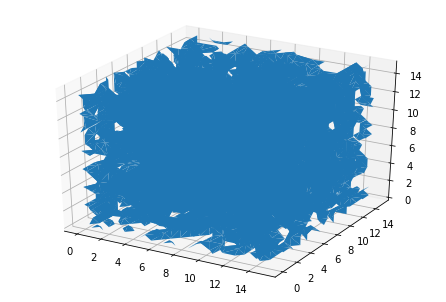

Model saved at _output/3d-vae-gan/model/epoch_160/model.ckpt
###########
Epoch 160 Completed
Elapsed Time: 76.39186865488688 mins
Epoch 161 Start
	Batch=0
Epoch 161 Completed
Elapsed Time: 76.8404657403628 mins
Epoch 162 Start
	Batch=0
Epoch 162 Completed
Elapsed Time: 77.28905239899953 mins
Epoch 163 Start
	Batch=0
Epoch 163 Completed
Elapsed Time: 77.74012826681137 mins
Epoch 164 Start
	Batch=0
Epoch 164 Completed
Elapsed Time: 78.19291173617044 mins
Epoch 165 Start
	Batch=0
Epoch 165 Completed
Elapsed Time: 78.64496763547261 mins
Epoch 166 Start
	Batch=0
Epoch 166 Completed
Elapsed Time: 79.10173096259435 mins
Epoch 167 Start
	Batch=0
Epoch 167 Completed
Elapsed Time: 79.55770624876023 mins
Epoch 168 Start
	Batch=0
Epoch 168 Completed
Elapsed Time: 80.0124038139979 mins
Epoch 169 Start
	Batch=0
Epoch 169 Completed
Elapsed Time: 80.46592588424683 mins
Epoch 170 Start
	Batch=0
###########
epoch:
D Loss: -0.010430217
G Loss: -0.009254303
VAE loss: 3735.8691
KL divergence: 747.1192
reco

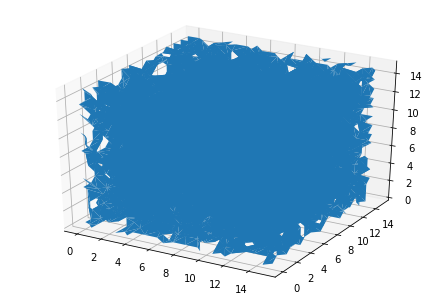

Model saved at _output/3d-vae-gan/model/epoch_170/model.ckpt
###########
Epoch 170 Completed
Elapsed Time: 81.09537688096364 mins
Epoch 171 Start
	Batch=0
Epoch 171 Completed
Elapsed Time: 81.54324580033621 mins
Epoch 172 Start
	Batch=0
Epoch 172 Completed
Elapsed Time: 81.99374959071477 mins
Epoch 173 Start
	Batch=0
Epoch 173 Completed
Elapsed Time: 82.44343727032343 mins
Epoch 174 Start
	Batch=0
Epoch 174 Completed
Elapsed Time: 82.89406016667684 mins
Epoch 175 Start
	Batch=0
Epoch 175 Completed
Elapsed Time: 83.3451558748881 mins
Epoch 176 Start
	Batch=0
Epoch 176 Completed
Elapsed Time: 83.7969753185908 mins
Epoch 177 Start
	Batch=0
Epoch 177 Completed
Elapsed Time: 84.24734407265981 mins
Epoch 178 Start
	Batch=0
Epoch 178 Completed
Elapsed Time: 84.6989678343137 mins
Epoch 179 Start
	Batch=0
Epoch 179 Completed
Elapsed Time: 85.14738452831904 mins
Epoch 180 Start
	Batch=0
###########
epoch:
D Loss: -0.009612045
G Loss: -0.009809002
VAE loss: 3253.3398
KL divergence: 650.6126
recon

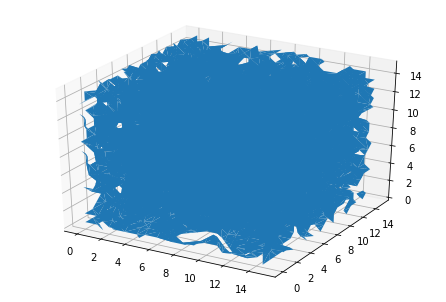

Model saved at _output/3d-vae-gan/model/epoch_180/model.ckpt
###########
Epoch 180 Completed
Elapsed Time: 85.79598427216212 mins
Epoch 181 Start
	Batch=0
Epoch 181 Completed
Elapsed Time: 86.24280184110006 mins
Epoch 182 Start
	Batch=0
Epoch 182 Completed
Elapsed Time: 86.69268129666646 mins
Epoch 183 Start
	Batch=0
Epoch 183 Completed
Elapsed Time: 87.1408811211586 mins
Epoch 184 Start
	Batch=0
Epoch 184 Completed
Elapsed Time: 87.5941899339358 mins
Epoch 185 Start
	Batch=0
Epoch 185 Completed
Elapsed Time: 88.04547657966614 mins
Epoch 186 Start
	Batch=0
Epoch 186 Completed
Elapsed Time: 88.49840160608292 mins
Epoch 187 Start
	Batch=0
Epoch 187 Completed
Elapsed Time: 88.94880380233128 mins
Epoch 188 Start
	Batch=0
Epoch 188 Completed
Elapsed Time: 89.39531616767248 mins
Epoch 189 Start
	Batch=0
Epoch 189 Completed
Elapsed Time: 89.84491864045461 mins
Epoch 190 Start
	Batch=0
###########
epoch:
D Loss: -0.017160214
G Loss: -0.017719582
VAE loss: 2287.7173
KL divergence: 457.4929
reco

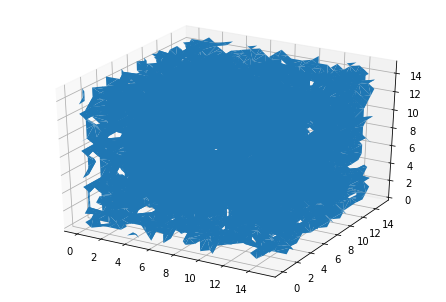

Model saved at _output/3d-vae-gan/model/epoch_190/model.ckpt
###########
Epoch 190 Completed
Elapsed Time: 90.47129133145015 mins
Epoch 191 Start
	Batch=0
Epoch 191 Completed
Elapsed Time: 90.92030665079753 mins
Epoch 192 Start
	Batch=0
Epoch 192 Completed
Elapsed Time: 91.37164473136266 mins
Epoch 193 Start
	Batch=0
Epoch 193 Completed
Elapsed Time: 91.82151031096777 mins
Epoch 194 Start
	Batch=0
Epoch 194 Completed
Elapsed Time: 92.27279783089956 mins
Epoch 195 Start
	Batch=0
Epoch 195 Completed
Elapsed Time: 92.72243855794271 mins
Epoch 196 Start
	Batch=0
Epoch 196 Completed
Elapsed Time: 93.17488189935685 mins
Epoch 197 Start
	Batch=0
Epoch 197 Completed
Elapsed Time: 93.62719002167384 mins
Epoch 198 Start
	Batch=0
Epoch 198 Completed
Elapsed Time: 94.07640447616578 mins
Epoch 199 Start
	Batch=0
Epoch 199 Completed
Elapsed Time: 94.52863645156225 mins
Epoch 200 Start
	Batch=0
###########
epoch:
D Loss: 0.04385547
G Loss: 0.04476353
VAE loss: 1865.2546
KL divergence: 373.00095
recon

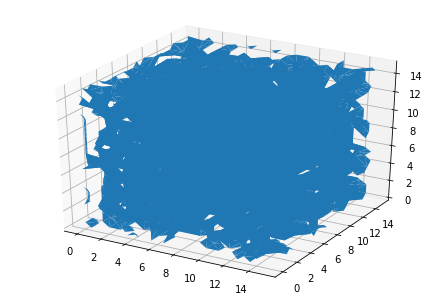

Model saved at _output/3d-vae-gan/model/epoch_200/model.ckpt
###########
Epoch 200 Completed
Elapsed Time: 95.14962131182352 mins
Epoch 201 Start
	Batch=0
Epoch 201 Completed
Elapsed Time: 95.59876533349355 mins
Epoch 202 Start
	Batch=0
Epoch 202 Completed
Elapsed Time: 96.05193382898966 mins
Epoch 203 Start
	Batch=0
Epoch 203 Completed
Elapsed Time: 96.5067760626475 mins
Epoch 204 Start
	Batch=0
Epoch 204 Completed
Elapsed Time: 96.9584747115771 mins
Epoch 205 Start
	Batch=0
Epoch 205 Completed
Elapsed Time: 97.41146707137426 mins
Epoch 206 Start
	Batch=0
Epoch 206 Completed
Elapsed Time: 97.86389731168747 mins
Epoch 207 Start
	Batch=0
Epoch 207 Completed
Elapsed Time: 98.31596817572911 mins
Epoch 208 Start
	Batch=0
Epoch 208 Completed
Elapsed Time: 98.7738790710767 mins
Epoch 209 Start
	Batch=0
Epoch 209 Completed
Elapsed Time: 99.22511359850566 mins
Epoch 210 Start
	Batch=0
###########
epoch:
D Loss: -0.036447767
G Loss: -0.035249174
VAE loss: 1680.5771
KL divergence: 336.06802
reco

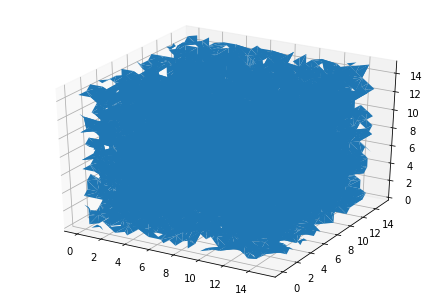

Model saved at _output/3d-vae-gan/model/epoch_210/model.ckpt
###########
Epoch 210 Completed
Elapsed Time: 99.85508939822515 mins
Epoch 211 Start
	Batch=0
Epoch 211 Completed
Elapsed Time: 100.30900568962097 mins
Epoch 212 Start
	Batch=0
Epoch 212 Completed
Elapsed Time: 100.7609309275945 mins
Epoch 213 Start
	Batch=0
Epoch 213 Completed
Elapsed Time: 101.21543486118317 mins
Epoch 214 Start
	Batch=0
Epoch 214 Completed
Elapsed Time: 101.66594706773758 mins
Epoch 215 Start
	Batch=0
Epoch 215 Completed
Elapsed Time: 102.11853818496068 mins
Epoch 216 Start
	Batch=0
Epoch 216 Completed
Elapsed Time: 102.5700860619545 mins
Epoch 217 Start
	Batch=0
Epoch 217 Completed
Elapsed Time: 103.02129006385803 mins
Epoch 218 Start
	Batch=0
Epoch 218 Completed
Elapsed Time: 103.47474109729131 mins
Epoch 219 Start
	Batch=0
Epoch 219 Completed
Elapsed Time: 103.92786800463995 mins
Epoch 220 Start
	Batch=0
###########
epoch:
D Loss: 0.0118398275
G Loss: 0.011158492
VAE loss: 2223.9548
KL divergence: 444.7

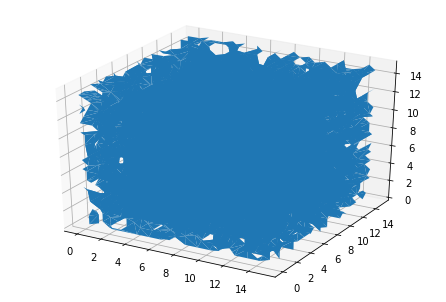

Model saved at _output/3d-vae-gan/model/epoch_220/model.ckpt
###########
Epoch 220 Completed
Elapsed Time: 104.55681344270707 mins
Epoch 221 Start
	Batch=0
Epoch 221 Completed
Elapsed Time: 105.00417629877727 mins
Epoch 222 Start
	Batch=0
Epoch 222 Completed
Elapsed Time: 105.45352009534835 mins
Epoch 223 Start
	Batch=0
Epoch 223 Completed
Elapsed Time: 105.9026676217715 mins
Epoch 224 Start
	Batch=0
Epoch 224 Completed
Elapsed Time: 106.35064602692923 mins
Epoch 225 Start
	Batch=0
Epoch 225 Completed
Elapsed Time: 106.80127976735433 mins
Epoch 226 Start
	Batch=0
Epoch 226 Completed
Elapsed Time: 107.25480949481329 mins
Epoch 227 Start
	Batch=0
Epoch 227 Completed
Elapsed Time: 107.7054177761078 mins
Epoch 228 Start
	Batch=0
Epoch 228 Completed
Elapsed Time: 108.15314262310663 mins
Epoch 229 Start
	Batch=0
Epoch 229 Completed
Elapsed Time: 108.60042370557785 mins
Epoch 230 Start
	Batch=0
###########
epoch:
D Loss: 0.028555831
G Loss: 0.02746986
VAE loss: 3203.2148
KL divergence: 640.58

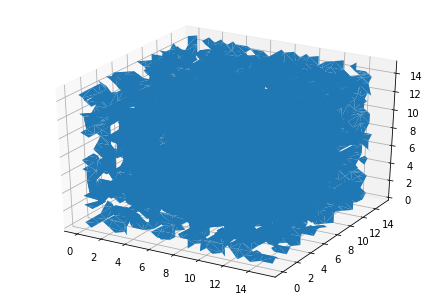

Model saved at _output/3d-vae-gan/model/epoch_230/model.ckpt
###########
Epoch 230 Completed
Elapsed Time: 109.22598912318547 mins
Epoch 231 Start
	Batch=0
Epoch 231 Completed
Elapsed Time: 109.67469339370727 mins
Epoch 232 Start
	Batch=0
Epoch 232 Completed
Elapsed Time: 110.12872844139734 mins
Epoch 233 Start
	Batch=0
Epoch 233 Completed
Elapsed Time: 110.57978694836298 mins
Epoch 234 Start
	Batch=0
Epoch 234 Completed
Elapsed Time: 111.02906907002131 mins
Epoch 235 Start
	Batch=0
Epoch 235 Completed
Elapsed Time: 111.47845357259115 mins
Epoch 236 Start
	Batch=0
Epoch 236 Completed
Elapsed Time: 111.92900275786718 mins
Epoch 237 Start
	Batch=0
Epoch 237 Completed
Elapsed Time: 112.37716323932013 mins
Epoch 238 Start
	Batch=0
Epoch 238 Completed
Elapsed Time: 112.82736765146255 mins
Epoch 239 Start
	Batch=0
Epoch 239 Completed
Elapsed Time: 113.28567795753479 mins
Epoch 240 Start
	Batch=0
###########
epoch:
D Loss: 0.0037368974
G Loss: 0.00449347
VAE loss: 3307.2207
KL divergence: 661

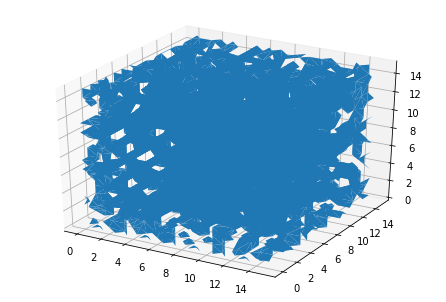

Model saved at _output/3d-vae-gan/model/epoch_240/model.ckpt
###########
Epoch 240 Completed
Elapsed Time: 113.91029803355535 mins
Epoch 241 Start
	Batch=0
Epoch 241 Completed
Elapsed Time: 114.35921996831894 mins
Epoch 242 Start
	Batch=0
Epoch 242 Completed
Elapsed Time: 114.81494922240576 mins
Epoch 243 Start
	Batch=0
Epoch 243 Completed
Elapsed Time: 115.26473307212194 mins
Epoch 244 Start
	Batch=0
Epoch 244 Completed
Elapsed Time: 115.7157754500707 mins
Epoch 245 Start
	Batch=0
Epoch 245 Completed
Elapsed Time: 116.16676293611526 mins
Epoch 246 Start
	Batch=0
Epoch 246 Completed
Elapsed Time: 116.62180456717809 mins
Epoch 247 Start
	Batch=0
Epoch 247 Completed
Elapsed Time: 117.07763977050782 mins
Epoch 248 Start
	Batch=0
Epoch 248 Completed
Elapsed Time: 117.53193493684132 mins
Epoch 249 Start
	Batch=0
Epoch 249 Completed
Elapsed Time: 117.98474530378978 mins
Epoch 250 Start
	Batch=0
###########
epoch:
D Loss: -0.009920556
G Loss: -0.007875594
VAE loss: 3922.475
KL divergence: 784

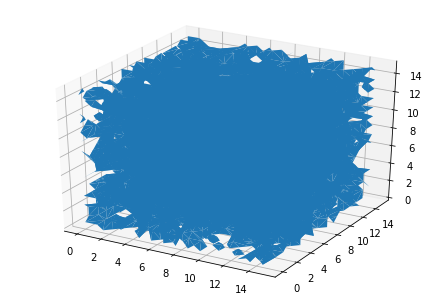

Model saved at _output/3d-vae-gan/model/epoch_250/model.ckpt
###########
Epoch 250 Completed
Elapsed Time: 118.60847072601318 mins
Epoch 251 Start
	Batch=0
Epoch 251 Completed
Elapsed Time: 119.05584196249644 mins
Epoch 252 Start
	Batch=0
Epoch 252 Completed
Elapsed Time: 119.5113925298055 mins
Epoch 253 Start
	Batch=0
Epoch 253 Completed
Elapsed Time: 119.96236230134964 mins
Epoch 254 Start
	Batch=0
Epoch 254 Completed
Elapsed Time: 120.41293822526931 mins
Epoch 255 Start
	Batch=0
Epoch 255 Completed
Elapsed Time: 120.85998133818309 mins
Epoch 256 Start
	Batch=0
Epoch 256 Completed
Elapsed Time: 121.31223735809326 mins
Epoch 257 Start
	Batch=0
Epoch 257 Completed
Elapsed Time: 121.76265402634938 mins
Epoch 258 Start
	Batch=0
Epoch 258 Completed
Elapsed Time: 122.21436063448589 mins
Epoch 259 Start
	Batch=0
Epoch 259 Completed
Elapsed Time: 122.66373051802317 mins
Epoch 260 Start
	Batch=0
###########
epoch:
D Loss: 0.011205391
G Loss: 0.010894177
VAE loss: 2517.5044
KL divergence: 503.

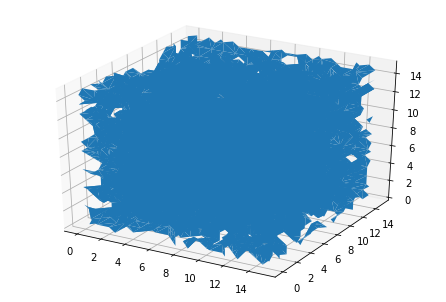

Model saved at _output/3d-vae-gan/model/epoch_260/model.ckpt
###########
Epoch 260 Completed
Elapsed Time: 123.29369821151097 mins
Epoch 261 Start
	Batch=0
Epoch 261 Completed
Elapsed Time: 123.74320139487584 mins
Epoch 262 Start
	Batch=0
Epoch 262 Completed
Elapsed Time: 124.19608892997105 mins
Epoch 263 Start
	Batch=0
Epoch 263 Completed
Elapsed Time: 124.64787152608235 mins
Epoch 264 Start
	Batch=0
Epoch 264 Completed
Elapsed Time: 125.09867464701334 mins
Epoch 265 Start
	Batch=0
Epoch 265 Completed
Elapsed Time: 125.54921517769496 mins
Epoch 266 Start
	Batch=0
Epoch 266 Completed
Elapsed Time: 125.9975744009018 mins
Epoch 267 Start
	Batch=0
Epoch 267 Completed
Elapsed Time: 126.45066783825557 mins
Epoch 268 Start
	Batch=0
Epoch 268 Completed
Elapsed Time: 126.90156478484472 mins
Epoch 269 Start
	Batch=0
Epoch 269 Completed
Elapsed Time: 127.35471569697062 mins
Epoch 270 Start
	Batch=0
###########
epoch:
D Loss: 0.016659988
G Loss: 0.014899811
VAE loss: 2738.3345
KL divergence: 547.

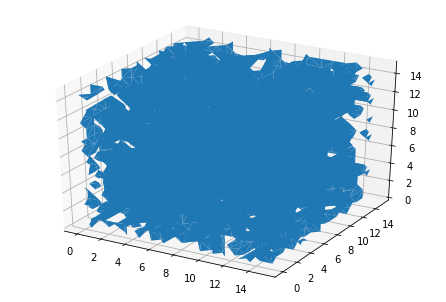

Model saved at _output/3d-vae-gan/model/epoch_270/model.ckpt
###########
Epoch 270 Completed
Elapsed Time: 127.98447067340216 mins
Epoch 271 Start
	Batch=0
Epoch 271 Completed
Elapsed Time: 128.43339290618897 mins
Epoch 272 Start
	Batch=0
Epoch 272 Completed
Elapsed Time: 128.8835775256157 mins
Epoch 273 Start
	Batch=0
Epoch 273 Completed
Elapsed Time: 129.3344256122907 mins
Epoch 274 Start
	Batch=0
Epoch 274 Completed
Elapsed Time: 129.78478088378907 mins
Epoch 275 Start
	Batch=0
Epoch 275 Completed
Elapsed Time: 130.23486133416495 mins
Epoch 276 Start
	Batch=0
Epoch 276 Completed
Elapsed Time: 130.68775668144227 mins
Epoch 277 Start
	Batch=0
Epoch 277 Completed
Elapsed Time: 131.1408822099368 mins
Epoch 278 Start
	Batch=0
Epoch 278 Completed
Elapsed Time: 131.59345390399298 mins
Epoch 279 Start
	Batch=0
Epoch 279 Completed
Elapsed Time: 132.0428452650706 mins
Epoch 280 Start
	Batch=0
###########
epoch:
D Loss: 0.00484546
G Loss: 0.00556807
VAE loss: 2821.1826
KL divergence: 564.1856


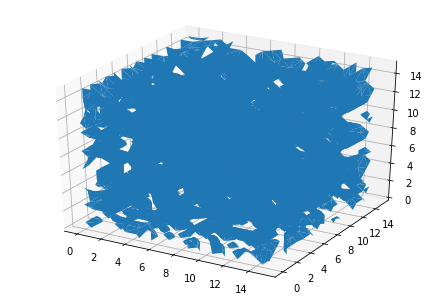

Model saved at _output/3d-vae-gan/model/epoch_280/model.ckpt
###########
Epoch 280 Completed
Elapsed Time: 132.6686062892278 mins
Epoch 281 Start
	Batch=0
Epoch 281 Completed
Elapsed Time: 133.11657100518545 mins
Epoch 282 Start
	Batch=0
Epoch 282 Completed
Elapsed Time: 133.56897042592365 mins
Epoch 283 Start
	Batch=0
Epoch 283 Completed
Elapsed Time: 134.0231442809105 mins
Epoch 284 Start
	Batch=0
Epoch 284 Completed
Elapsed Time: 134.47328896919888 mins
Epoch 285 Start
	Batch=0
Epoch 285 Completed
Elapsed Time: 134.9251679499944 mins
Epoch 286 Start
	Batch=0
Epoch 286 Completed
Elapsed Time: 135.37751579284668 mins
Epoch 287 Start
	Batch=0
Epoch 287 Completed
Elapsed Time: 135.83220221598944 mins
Epoch 288 Start
	Batch=0
Epoch 288 Completed
Elapsed Time: 136.28440505663553 mins
Epoch 289 Start
	Batch=0
Epoch 289 Completed
Elapsed Time: 136.73960544665655 mins
Epoch 290 Start
	Batch=0
###########
epoch:
D Loss: 0.035844322
G Loss: 0.037431154
VAE loss: 2896.349
KL divergence: 579.219

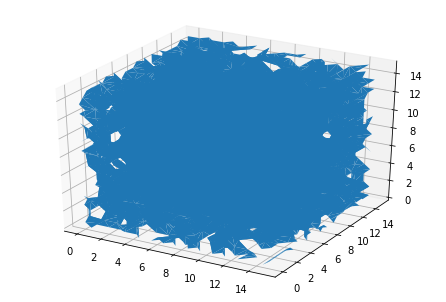

Model saved at _output/3d-vae-gan/model/epoch_290/model.ckpt
###########
Epoch 290 Completed
Elapsed Time: 137.3767402927081 mins
Epoch 291 Start
	Batch=0
Epoch 291 Completed
Elapsed Time: 137.82833879391353 mins
Epoch 292 Start
	Batch=0
Epoch 292 Completed
Elapsed Time: 138.28020677963892 mins
Epoch 293 Start
	Batch=0
Epoch 293 Completed
Elapsed Time: 138.73433976570766 mins
Epoch 294 Start
	Batch=0
Epoch 294 Completed
Elapsed Time: 139.18646238644916 mins
Epoch 295 Start
	Batch=0
Epoch 295 Completed
Elapsed Time: 139.63495422204335 mins
Epoch 296 Start
	Batch=0
Epoch 296 Completed
Elapsed Time: 140.08610641558965 mins
Epoch 297 Start
	Batch=0
Epoch 297 Completed
Elapsed Time: 140.53690878947575 mins
Epoch 298 Start
	Batch=0
Epoch 302 Completed
Elapsed Time: 142.98728763659796 mins
Epoch 303 Start
	Batch=0
Epoch 303 Completed
Elapsed Time: 143.4380468805631 mins
Epoch 304 Start
	Batch=0
Epoch 304 Completed
Elapsed Time: 143.89218717813492 mins
Epoch 305 Start
	Batch=0
Epoch 305 Comple

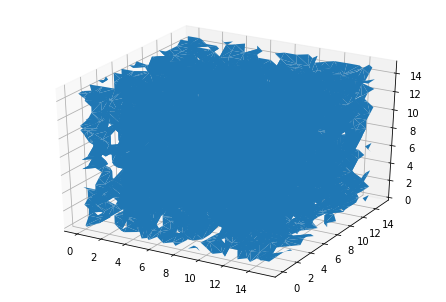

Model saved at _output/3d-vae-gan/model/epoch_310/model.ckpt
###########
Epoch 310 Completed
Elapsed Time: 146.79438944657645 mins
Epoch 311 Start
	Batch=0
Epoch 311 Completed
Elapsed Time: 147.244177989165 mins
Epoch 312 Start
	Batch=0
Epoch 312 Completed
Elapsed Time: 147.6925402998924 mins
Epoch 313 Start
	Batch=0
Epoch 313 Completed
Elapsed Time: 148.1446102897326 mins
Epoch 314 Start
	Batch=0
Epoch 314 Completed
Elapsed Time: 148.601746070385 mins
Epoch 315 Start
	Batch=0
Epoch 315 Completed
Elapsed Time: 149.05478726625444 mins
Epoch 316 Start
	Batch=0
Epoch 316 Completed
Elapsed Time: 149.50396309693653 mins
Epoch 317 Start
	Batch=0
Epoch 317 Completed
Elapsed Time: 149.95384012063343 mins
Epoch 318 Start
	Batch=0
Epoch 318 Completed
Elapsed Time: 150.40457999706268 mins
Epoch 319 Start
	Batch=0
Epoch 319 Completed
Elapsed Time: 150.85858517885208 mins
Epoch 320 Start
	Batch=0
###########
epoch:
D Loss: 0.014513523
G Loss: 0.014038954
VAE loss: 3643.91
KL divergence: 728.73175
r

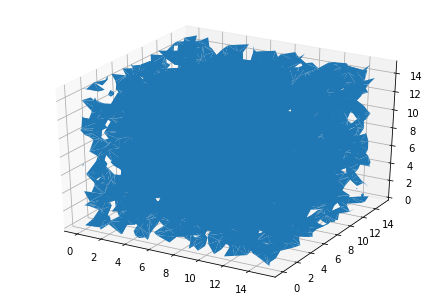

Model saved at _output/3d-vae-gan/model/epoch_320/model.ckpt
###########
Epoch 320 Completed
Elapsed Time: 151.4857722600301 mins
Epoch 321 Start
	Batch=0
Epoch 321 Completed
Elapsed Time: 151.93466384808224 mins
Epoch 322 Start
	Batch=0
Epoch 322 Completed
Elapsed Time: 152.39107180039088 mins
Epoch 323 Start
	Batch=0
Epoch 323 Completed
Elapsed Time: 152.8419460495313 mins
Epoch 324 Start
	Batch=0
Epoch 324 Completed
Elapsed Time: 153.29485911925633 mins
Epoch 325 Start
	Batch=0
Epoch 325 Completed
Elapsed Time: 153.74874030749004 mins
Epoch 326 Start
	Batch=0
Epoch 326 Completed
Elapsed Time: 154.20164908568066 mins
Epoch 327 Start
	Batch=0
Epoch 327 Completed
Elapsed Time: 154.65513557593027 mins
Epoch 328 Start
	Batch=0
Epoch 328 Completed
Elapsed Time: 155.10843166510264 mins
Epoch 329 Start
	Batch=0
Epoch 329 Completed
Elapsed Time: 155.55969413518906 mins
Epoch 330 Start
	Batch=0
###########
epoch:
D Loss: 0.015292957
G Loss: 0.016746238
VAE loss: 5270.1025
KL divergence: 1053.

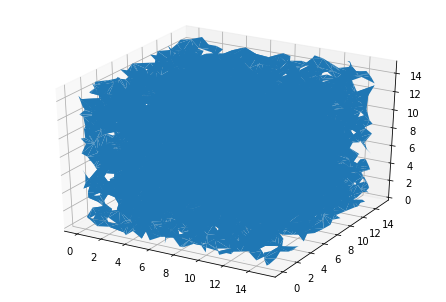

Model saved at _output/3d-vae-gan/model/epoch_330/model.ckpt
###########
Epoch 330 Completed
Elapsed Time: 156.1939301967621 mins
Epoch 331 Start
	Batch=0
Epoch 331 Completed
Elapsed Time: 156.6414170384407 mins
Epoch 332 Start
	Batch=0
Epoch 332 Completed
Elapsed Time: 157.0963547507922 mins
Epoch 333 Start
	Batch=0
Epoch 333 Completed
Elapsed Time: 157.5521722237269 mins
Epoch 334 Start
	Batch=0
Epoch 334 Completed
Elapsed Time: 158.00642900069553 mins
Epoch 335 Start
	Batch=0
Epoch 335 Completed
Elapsed Time: 158.46074655850728 mins
Epoch 336 Start
	Batch=0
Epoch 336 Completed
Elapsed Time: 158.91423964103063 mins
Epoch 337 Start
	Batch=0
Epoch 337 Completed
Elapsed Time: 159.36476427316666 mins
Epoch 338 Start
	Batch=0
Epoch 338 Completed
Elapsed Time: 159.81891964673997 mins
Epoch 339 Start
	Batch=0
Epoch 339 Completed
Elapsed Time: 160.2708296895027 mins
Epoch 340 Start
	Batch=0
###########
epoch:
D Loss: -0.013404942
G Loss: -0.013346539
VAE loss: 6968.498
KL divergence: 1393.64

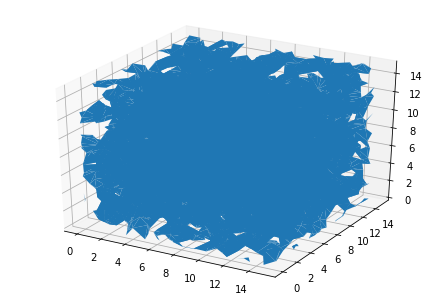

Model saved at _output/3d-vae-gan/model/epoch_340/model.ckpt
###########
Epoch 340 Completed
Elapsed Time: 160.89904353221257 mins
Epoch 341 Start
	Batch=0
Epoch 341 Completed
Elapsed Time: 161.3533248702685 mins
Epoch 342 Start
	Batch=0
Epoch 342 Completed
Elapsed Time: 161.8089655637741 mins
Epoch 343 Start
	Batch=0
Epoch 343 Completed
Elapsed Time: 162.26039584477743 mins
Epoch 344 Start
	Batch=0
Epoch 344 Completed
Elapsed Time: 162.71310204664866 mins
Epoch 345 Start
	Batch=0
Epoch 345 Completed
Elapsed Time: 163.1647827943166 mins
Epoch 346 Start
	Batch=0
Epoch 346 Completed
Elapsed Time: 163.61880842844644 mins
Epoch 347 Start
	Batch=0
Epoch 347 Completed
Elapsed Time: 164.07255123853685 mins
Epoch 348 Start
	Batch=0
Epoch 348 Completed
Elapsed Time: 164.52712604602178 mins
Epoch 349 Start
	Batch=0
Epoch 349 Completed
Elapsed Time: 164.9829542438189 mins
Epoch 350 Start
	Batch=0
###########
epoch:
D Loss: 0.00018200255
G Loss: -0.0013753114
VAE loss: 6469.701
KL divergence: 1293

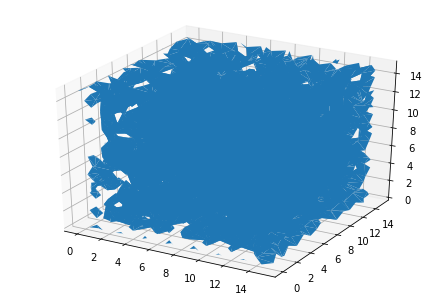

Model saved at _output/3d-vae-gan/model/epoch_350/model.ckpt
###########
Epoch 350 Completed
Elapsed Time: 165.60868502457936 mins
Epoch 351 Start
	Batch=0
Epoch 351 Completed
Elapsed Time: 166.05965165694553 mins
Epoch 352 Start
	Batch=0
Epoch 352 Completed
Elapsed Time: 166.51352883974712 mins
Epoch 353 Start
	Batch=0
Epoch 353 Completed
Elapsed Time: 166.9649150808652 mins
Epoch 354 Start
	Batch=0
Epoch 354 Completed
Elapsed Time: 167.42055288155873 mins
Epoch 355 Start
	Batch=0
Epoch 355 Completed
Elapsed Time: 167.87800736427306 mins
Epoch 356 Start
	Batch=0
Epoch 356 Completed
Elapsed Time: 168.331217110157 mins
Epoch 357 Start
	Batch=0
Epoch 357 Completed
Elapsed Time: 168.78179021676382 mins
Epoch 358 Start
	Batch=0
Epoch 358 Completed
Elapsed Time: 169.234232989947 mins
Epoch 359 Start
	Batch=0
Epoch 359 Completed
Elapsed Time: 169.69347633918127 mins
Epoch 360 Start
	Batch=0
###########
epoch:
D Loss: 0.0003324856
G Loss: 0.0007736684
VAE loss: 6385.424
KL divergence: 1277.02

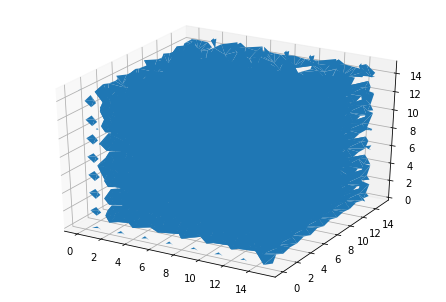

Model saved at _output/3d-vae-gan/model/epoch_360/model.ckpt
###########
Epoch 360 Completed
Elapsed Time: 170.3256266236305 mins
Epoch 361 Start
	Batch=0
Epoch 361 Completed
Elapsed Time: 170.77261994679768 mins
Epoch 362 Start
	Batch=0
Epoch 362 Completed
Elapsed Time: 171.22818709214528 mins
Epoch 363 Start
	Batch=0
Epoch 363 Completed
Elapsed Time: 171.68124969800314 mins
Epoch 364 Start
	Batch=0
Epoch 364 Completed
Elapsed Time: 172.13569383621217 mins
Epoch 365 Start
	Batch=0
Epoch 365 Completed
Elapsed Time: 172.58861705064774 mins
Epoch 366 Start
	Batch=0
Epoch 366 Completed
Elapsed Time: 173.04130387703577 mins
Epoch 367 Start
	Batch=0
Epoch 367 Completed
Elapsed Time: 173.49344919522602 mins
Epoch 368 Start
	Batch=0
Epoch 368 Completed
Elapsed Time: 173.9467079281807 mins
Epoch 369 Start
	Batch=0
Epoch 369 Completed
Elapsed Time: 174.4044768691063 mins
Epoch 370 Start
	Batch=0
###########
epoch:
D Loss: 0.022278324
G Loss: 0.023604944
VAE loss: 6932.561
KL divergence: 1386.46

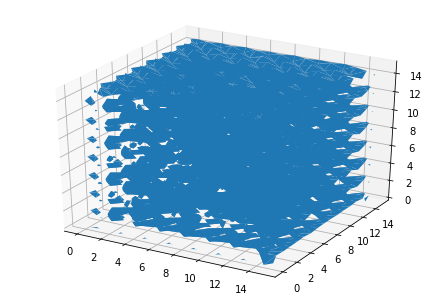

Model saved at _output/3d-vae-gan/model/epoch_370/model.ckpt
###########
Epoch 370 Completed
Elapsed Time: 175.02909752527873 mins
Epoch 371 Start
	Batch=0
Epoch 371 Completed
Elapsed Time: 175.4772756377856 mins
Epoch 372 Start
	Batch=0
Epoch 372 Completed
Elapsed Time: 175.92807605663936 mins
Epoch 373 Start
	Batch=0
Epoch 373 Completed
Elapsed Time: 176.3813650091489 mins
Epoch 374 Start
	Batch=0
Epoch 374 Completed
Elapsed Time: 176.8300453543663 mins
Epoch 375 Start
	Batch=0
Epoch 375 Completed
Elapsed Time: 177.28502297798792 mins
Epoch 376 Start
	Batch=0
Epoch 376 Completed
Elapsed Time: 177.73866844177246 mins
Epoch 377 Start
	Batch=0
Epoch 377 Completed
Elapsed Time: 178.19033667643865 mins
Epoch 378 Start
	Batch=0
Epoch 378 Completed
Elapsed Time: 178.64243372678757 mins
Epoch 379 Start
	Batch=0
Epoch 379 Completed
Elapsed Time: 179.0921630859375 mins
Epoch 380 Start
	Batch=0
###########
epoch:
D Loss: -0.004234981
G Loss: -0.0051893853
VAE loss: 7294.089
KL divergence: 1458.

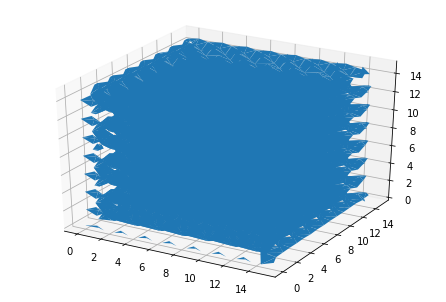

Model saved at _output/3d-vae-gan/model/epoch_380/model.ckpt
###########
Epoch 380 Completed
Elapsed Time: 179.72704398234686 mins
Epoch 381 Start
	Batch=0
Epoch 381 Completed
Elapsed Time: 180.17965337832769 mins
Epoch 382 Start
	Batch=0
Epoch 382 Completed
Elapsed Time: 180.63457139730454 mins
Epoch 383 Start
	Batch=0
Epoch 383 Completed
Elapsed Time: 181.08159687916438 mins
Epoch 384 Start
	Batch=0
Epoch 384 Completed
Elapsed Time: 181.5325219790141 mins
Epoch 385 Start
	Batch=0
Epoch 385 Completed
Elapsed Time: 181.98588023583093 mins
Epoch 386 Start
	Batch=0
Epoch 386 Completed
Elapsed Time: 182.43983685572942 mins
Epoch 387 Start
	Batch=0
Epoch 387 Completed
Elapsed Time: 182.8918981830279 mins
Epoch 388 Start
	Batch=0
Epoch 388 Completed
Elapsed Time: 183.34220647017162 mins
Epoch 389 Start
	Batch=0
Epoch 389 Completed
Elapsed Time: 183.79972426891328 mins
Epoch 390 Start
	Batch=0
###########
epoch:
D Loss: 0.009139188
G Loss: 0.009297451
VAE loss: 6949.24
KL divergence: 1389.79

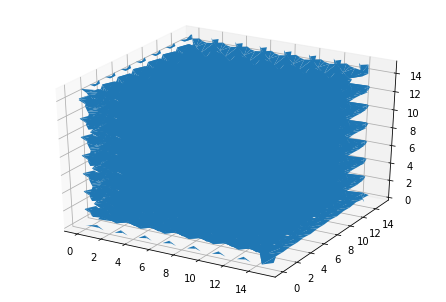

Model saved at _output/3d-vae-gan/model/epoch_390/model.ckpt
###########
Epoch 390 Completed
Elapsed Time: 184.42865346272785 mins
Epoch 391 Start
	Batch=0
Epoch 395 Completed
Elapsed Time: 186.6897945801417 mins
Epoch 396 Start
	Batch=0
Epoch 396 Completed
Elapsed Time: 187.1433975259463 mins
Epoch 397 Start
	Batch=0
Epoch 397 Completed
Elapsed Time: 187.59835816224415 mins
Epoch 398 Start
	Batch=0
Epoch 398 Completed
Elapsed Time: 188.04740195274354 mins
Epoch 399 Start
	Batch=0
Epoch 399 Completed
Elapsed Time: 188.49825726747514 mins
Epoch 400 Start
	Batch=0
###########
epoch:
D Loss: -0.015347809
G Loss: -0.013806804
VAE loss: 6815.1045
KL divergence: 1362.9741
reconstruction_loss: 2102263.5


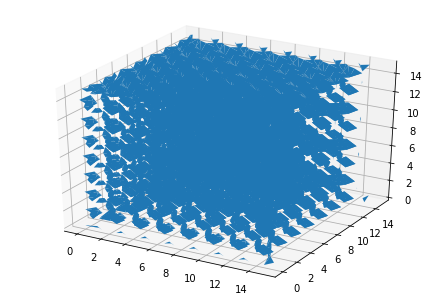

Model saved at _output/3d-vae-gan/model/epoch_400/model.ckpt
###########
Epoch 400 Completed
Elapsed Time: 189.12375528415043 mins
Epoch 401 Start
	Batch=0
Epoch 401 Completed
Elapsed Time: 189.5772767821948 mins
Epoch 402 Start
	Batch=0
Epoch 402 Completed
Elapsed Time: 190.02788823445638 mins
Epoch 403 Start
	Batch=0
Epoch 403 Completed
Elapsed Time: 190.47854227224985 mins
Epoch 404 Start
	Batch=0
Epoch 404 Completed
Elapsed Time: 190.93257248401642 mins
Epoch 405 Start
	Batch=0
Epoch 405 Completed
Elapsed Time: 191.38684732516606 mins
Epoch 406 Start
	Batch=0
Epoch 406 Completed
Elapsed Time: 191.8422421137492 mins
Epoch 407 Start
	Batch=0
Epoch 407 Completed
Elapsed Time: 192.29296177228292 mins
Epoch 408 Start
	Batch=0
Epoch 408 Completed
Elapsed Time: 192.74806860287984 mins
Epoch 409 Start
	Batch=0
Epoch 409 Completed
Elapsed Time: 193.1983452041944 mins
Epoch 410 Start
	Batch=0
###########
epoch:
D Loss: 0.02793441
G Loss: 0.02696888
VAE loss: 5898.6094
KL divergence: 1179.674

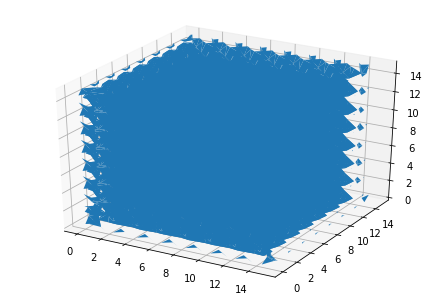

Model saved at _output/3d-vae-gan/model/epoch_410/model.ckpt
###########
Epoch 410 Completed
Elapsed Time: 193.82859623829523 mins
Epoch 411 Start
	Batch=0
Epoch 411 Completed
Elapsed Time: 194.27615780433018 mins
Epoch 412 Start
	Batch=0
Epoch 412 Completed
Elapsed Time: 194.73106734752656 mins
Epoch 413 Start
	Batch=0
Epoch 413 Completed
Elapsed Time: 195.17923471927642 mins
Epoch 414 Start
	Batch=0
Epoch 414 Completed
Elapsed Time: 195.63015741507212 mins
Epoch 415 Start
	Batch=0
Epoch 415 Completed
Elapsed Time: 196.07828429539998 mins
Epoch 416 Start
	Batch=0
Epoch 416 Completed
Elapsed Time: 196.5344047466914 mins
Epoch 417 Start
	Batch=0
Epoch 417 Completed
Elapsed Time: 196.98754129807153 mins
Epoch 418 Start
	Batch=0
Epoch 418 Completed
Elapsed Time: 197.43940138022106 mins
Epoch 419 Start
	Batch=0
Epoch 419 Completed
Elapsed Time: 197.89304117361704 mins
Epoch 420 Start
	Batch=0
###########
epoch:
D Loss: -0.012839092
G Loss: -0.014087306
VAE loss: 5640.946
KL divergence: 112

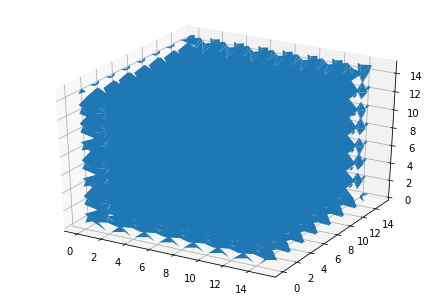

Model saved at _output/3d-vae-gan/model/epoch_420/model.ckpt
###########
Epoch 420 Completed
Elapsed Time: 198.5294842004776 mins
Epoch 421 Start
	Batch=0
Epoch 421 Completed
Elapsed Time: 198.97997905015944 mins
Epoch 422 Start
	Batch=0
Epoch 422 Completed
Elapsed Time: 199.43676826556523 mins
Epoch 423 Start
	Batch=0
Epoch 423 Completed
Elapsed Time: 199.88859089215597 mins
Epoch 424 Start
	Batch=0
Epoch 424 Completed
Elapsed Time: 200.34196226596833 mins
Epoch 425 Start
	Batch=0
Epoch 425 Completed
Elapsed Time: 200.79080821673077 mins
Epoch 426 Start
	Batch=0
Epoch 426 Completed
Elapsed Time: 201.24143373568853 mins
Epoch 427 Start
	Batch=0
Epoch 427 Completed
Elapsed Time: 201.69872539440792 mins
Epoch 428 Start
	Batch=0
Epoch 428 Completed
Elapsed Time: 202.14896414279937 mins
Epoch 429 Start
	Batch=0
Epoch 429 Completed
Elapsed Time: 202.6013772924741 mins
Epoch 430 Start
	Batch=0
###########
epoch:
D Loss: 0.046901483
G Loss: 0.048531864
VAE loss: 4756.422
KL divergence: 951.23

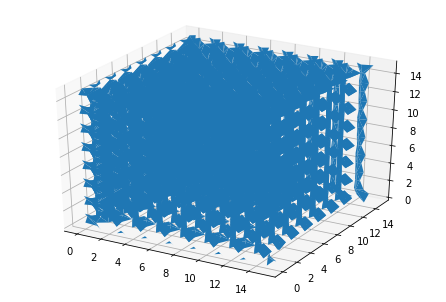

Model saved at _output/3d-vae-gan/model/epoch_430/model.ckpt
###########
Epoch 430 Completed
Elapsed Time: 203.23076357444128 mins
Epoch 431 Start
	Batch=0
Epoch 431 Completed
Elapsed Time: 203.68137644926708 mins
Epoch 432 Start
	Batch=0
Epoch 432 Completed
Elapsed Time: 204.13483294645945 mins
Epoch 433 Start
	Batch=0
Epoch 433 Completed
Elapsed Time: 204.5868716756503 mins
Epoch 434 Start
	Batch=0
Epoch 434 Completed
Elapsed Time: 205.04300523598988 mins
Epoch 435 Start
	Batch=0
Epoch 435 Completed
Elapsed Time: 205.49642697572708 mins
Epoch 436 Start
	Batch=0
Epoch 436 Completed
Elapsed Time: 205.9453932563464 mins
Epoch 437 Start
	Batch=0
Epoch 437 Completed
Elapsed Time: 206.39751745462416 mins
Epoch 438 Start
	Batch=0
Epoch 438 Completed
Elapsed Time: 206.85226927995683 mins
Epoch 439 Start
	Batch=0
Epoch 439 Completed
Elapsed Time: 207.30494286616644 mins
Epoch 440 Start
	Batch=0
###########
epoch:
D Loss: 0.0005976363
G Loss: 0.0012413752
VAE loss: 6183.171
KL divergence: 1236

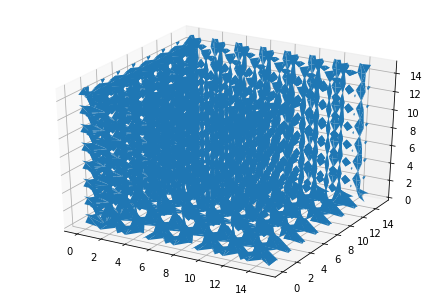

Model saved at _output/3d-vae-gan/model/epoch_440/model.ckpt
###########
Epoch 440 Completed
Elapsed Time: 207.93518021504084 mins
Epoch 441 Start
	Batch=0
Epoch 441 Completed
Elapsed Time: 208.3837101538976 mins
Epoch 442 Start
	Batch=0
Epoch 442 Completed
Elapsed Time: 208.83511013587315 mins
Epoch 443 Start
	Batch=0
Epoch 443 Completed
Elapsed Time: 209.29150809049605 mins
Epoch 444 Start
	Batch=0
Epoch 444 Completed
Elapsed Time: 209.74451275666556 mins
Epoch 445 Start
	Batch=0
Epoch 445 Completed
Elapsed Time: 210.19867212375004 mins
Epoch 446 Start
	Batch=0
Epoch 446 Completed
Elapsed Time: 210.65107758839926 mins
Epoch 447 Start
	Batch=0
Epoch 447 Completed
Elapsed Time: 211.10413922468823 mins
Epoch 448 Start
	Batch=0
Epoch 448 Completed
Elapsed Time: 211.5545762062073 mins
Epoch 449 Start
	Batch=0
Epoch 449 Completed
Elapsed Time: 212.00855729579925 mins
Epoch 450 Start
	Batch=0
###########
epoch:
D Loss: 0.041463234
G Loss: 0.039180137
VAE loss: 6267.4873
KL divergence: 1253.

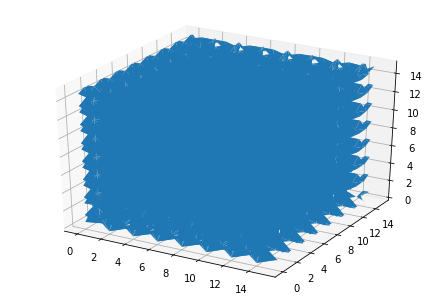

Model saved at _output/3d-vae-gan/model/epoch_450/model.ckpt
###########
Epoch 450 Completed
Elapsed Time: 212.641084531943 mins
Epoch 451 Start
	Batch=0
Epoch 451 Completed
Elapsed Time: 213.0924570918083 mins
Epoch 452 Start
	Batch=0
Epoch 452 Completed
Elapsed Time: 213.54357401529947 mins
Epoch 453 Start
	Batch=0
Epoch 453 Completed
Elapsed Time: 213.99663415749868 mins
Epoch 454 Start
	Batch=0
Epoch 454 Completed
Elapsed Time: 214.44651320377986 mins
Epoch 455 Start
	Batch=0
Epoch 455 Completed
Elapsed Time: 214.8985034108162 mins
Epoch 456 Start
	Batch=0
Epoch 456 Completed
Elapsed Time: 215.3511806845665 mins
Epoch 457 Start
	Batch=0
Epoch 457 Completed
Elapsed Time: 215.80177776416141 mins
Epoch 458 Start
	Batch=0
Epoch 458 Completed
Elapsed Time: 216.25209519863128 mins
Epoch 459 Start
	Batch=0
Epoch 459 Completed
Elapsed Time: 216.70284776687623 mins
Epoch 460 Start
	Batch=0
###########
epoch:
D Loss: 0.023964314
G Loss: 0.02383191
VAE loss: 5913.417
KL divergence: 1182.6277


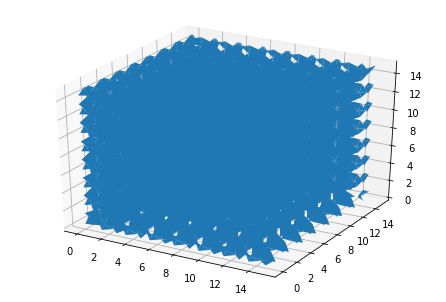

Model saved at _output/3d-vae-gan/model/epoch_460/model.ckpt
###########
Epoch 460 Completed
Elapsed Time: 217.33540651400884 mins
Epoch 461 Start
	Batch=0
Epoch 461 Completed
Elapsed Time: 217.78685474793116 mins
Epoch 462 Start
	Batch=0
Epoch 462 Completed
Elapsed Time: 218.23624217907587 mins
Epoch 463 Start
	Batch=0
Epoch 463 Completed
Elapsed Time: 218.6896195411682 mins
Epoch 464 Start
	Batch=0
Epoch 464 Completed
Elapsed Time: 219.14240236282347 mins
Epoch 465 Start
	Batch=0
Epoch 465 Completed
Elapsed Time: 219.5952618678411 mins
Epoch 466 Start
	Batch=0
Epoch 466 Completed
Elapsed Time: 220.04448996384937 mins
Epoch 467 Start
	Batch=0
Epoch 467 Completed
Elapsed Time: 220.50067444642386 mins
Epoch 468 Start
	Batch=0
Epoch 468 Completed
Elapsed Time: 220.95258571306866 mins
Epoch 469 Start
	Batch=0
Epoch 469 Completed
Elapsed Time: 221.41003059943517 mins
Epoch 470 Start
	Batch=0
###########
epoch:
D Loss: -0.016620371
G Loss: -0.015192694
VAE loss: 5316.335
KL divergence: 1063

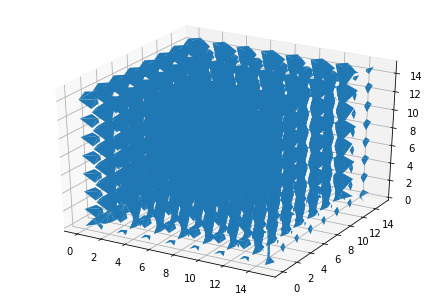

Model saved at _output/3d-vae-gan/model/epoch_470/model.ckpt
###########
Epoch 470 Completed
Elapsed Time: 222.03874601523083 mins
Epoch 471 Start
	Batch=0
Epoch 471 Completed
Elapsed Time: 222.4888071854909 mins
Epoch 472 Start
	Batch=0
Epoch 472 Completed
Elapsed Time: 222.94427534739177 mins
Epoch 473 Start
	Batch=0
Epoch 473 Completed
Elapsed Time: 223.3957427899043 mins
Epoch 474 Start
	Batch=0
Epoch 474 Completed
Elapsed Time: 223.84814321597418 mins
Epoch 475 Start
	Batch=0
Epoch 475 Completed
Elapsed Time: 224.30235967238744 mins
Epoch 476 Start
	Batch=0
Epoch 476 Completed
Elapsed Time: 224.75289798180262 mins
Epoch 477 Start
	Batch=0
Epoch 477 Completed
Elapsed Time: 225.21108212073645 mins
Epoch 478 Start
	Batch=0
Epoch 478 Completed
Elapsed Time: 225.66453825632732 mins
Epoch 479 Start
	Batch=0
Epoch 479 Completed
Elapsed Time: 226.11791026989619 mins
Epoch 480 Start
	Batch=0
###########
epoch:
D Loss: 0.008255386
G Loss: 0.008047835
VAE loss: 4510.497
KL divergence: 902.05

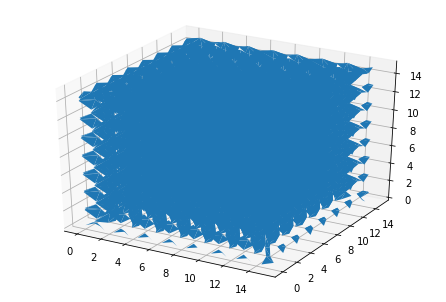

Model saved at _output/3d-vae-gan/model/epoch_480/model.ckpt
###########
Epoch 480 Completed
Elapsed Time: 226.7531352877617 mins
Epoch 481 Start
	Batch=0
Epoch 481 Completed
Elapsed Time: 227.20105485121408 mins
Epoch 482 Start
	Batch=0
Epoch 482 Completed
Elapsed Time: 227.6567310611407 mins
Epoch 483 Start
	Batch=0
Epoch 483 Completed
Elapsed Time: 228.1123181462288 mins
Epoch 484 Start
	Batch=0
Epoch 484 Completed
Elapsed Time: 228.5655104716619 mins
Epoch 485 Start
	Batch=0
Epoch 485 Completed
Elapsed Time: 229.01981599728268 mins
Epoch 486 Start
	Batch=0
Epoch 486 Completed
Elapsed Time: 229.47320750951766 mins
Epoch 487 Start
	Batch=0
Epoch 487 Completed
Elapsed Time: 229.92596167325974 mins
Epoch 488 Start
	Batch=0
Epoch 488 Completed
Elapsed Time: 230.37886363267899 mins
Epoch 489 Start
	Batch=0
Epoch 489 Completed
Elapsed Time: 230.83316225210825 mins
Epoch 490 Start
	Batch=0
###########
epoch:
D Loss: -0.000152439
G Loss: -0.0012617252
VAE loss: 4142.108
KL divergence: 828.3

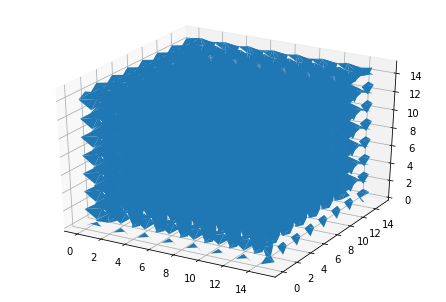

Model saved at _output/3d-vae-gan/model/epoch_490/model.ckpt
###########
Epoch 490 Completed
Elapsed Time: 231.4580391685168 mins
Epoch 491 Start
	Batch=0
Epoch 491 Completed
Elapsed Time: 231.9068363348643 mins
Epoch 492 Start
	Batch=0
Epoch 492 Completed
Elapsed Time: 232.3592910528183 mins
Epoch 493 Start
	Batch=0
Epoch 493 Completed
Elapsed Time: 232.81351075172424 mins
Epoch 494 Start
	Batch=0
Epoch 494 Completed
Elapsed Time: 233.2668013970057 mins
Epoch 495 Start
	Batch=0
Epoch 495 Completed
Elapsed Time: 233.71976142326992 mins
Epoch 496 Start
	Batch=0
Epoch 496 Completed
Elapsed Time: 234.176817715168 mins
Epoch 497 Start
	Batch=0
Epoch 497 Completed
Elapsed Time: 234.62936566670734 mins
Epoch 498 Start
	Batch=0
Epoch 498 Completed
Elapsed Time: 235.08086298306782 mins
Epoch 499 Start
	Batch=0
Epoch 499 Completed
Elapsed Time: 235.53329498370488 mins
Epoch 500 Start
	Batch=0
###########
epoch:
D Loss: 0.037207708
G Loss: 0.03840249
VAE loss: 3722.3687
KL divergence: 744.423
re

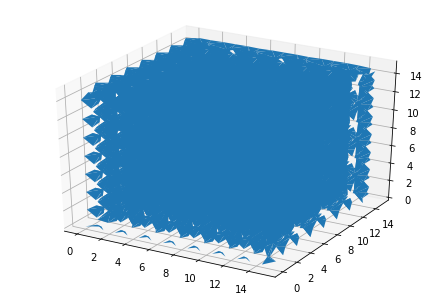

Model saved at _output/3d-vae-gan/model/epoch_500/model.ckpt
###########
Epoch 500 Completed
Elapsed Time: 236.16568760474522 mins
Epoch 501 Start
	Batch=0
Epoch 501 Completed
Elapsed Time: 236.61494235992433 mins
Epoch 502 Start
	Batch=0
Epoch 502 Completed
Elapsed Time: 237.06813712914786 mins
Epoch 503 Start
	Batch=0
Epoch 503 Completed
Elapsed Time: 237.52227498292922 mins
Epoch 504 Start
	Batch=0
Epoch 504 Completed
Elapsed Time: 237.97233044703802 mins
Epoch 505 Start
	Batch=0
Epoch 505 Completed
Elapsed Time: 238.42594081958134 mins
Epoch 506 Start
	Batch=0
Epoch 506 Completed
Elapsed Time: 238.87655087709427 mins
Epoch 507 Start
	Batch=0
Epoch 507 Completed
Elapsed Time: 239.3307499051094 mins
Epoch 508 Start
	Batch=0
Epoch 508 Completed
Elapsed Time: 239.7867736140887 mins
Epoch 509 Start
	Batch=0
Epoch 509 Completed
Elapsed Time: 240.23958940108616 mins
Epoch 510 Start
	Batch=0
###########
epoch:
D Loss: 0.010123779
G Loss: 0.01135759
VAE loss: 4605.8716
KL divergence: 921.12

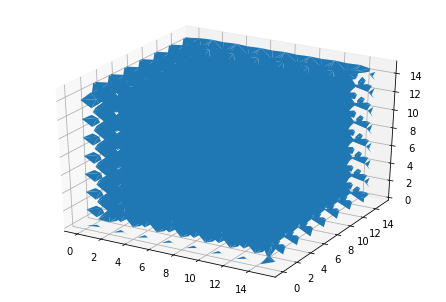

Model saved at _output/3d-vae-gan/model/epoch_510/model.ckpt
###########
Epoch 510 Completed
Elapsed Time: 240.86820518175762 mins
Epoch 511 Start
	Batch=0
Epoch 511 Completed
Elapsed Time: 241.319578063488 mins
Epoch 512 Start
	Batch=0
Epoch 512 Completed
Elapsed Time: 241.77534914016724 mins
Epoch 513 Start
	Batch=0
Epoch 513 Completed
Elapsed Time: 242.2272190173467 mins
Epoch 514 Start
	Batch=0
Epoch 514 Completed
Elapsed Time: 242.68377281427382 mins
Epoch 515 Start
	Batch=0
Epoch 515 Completed
Elapsed Time: 243.13407079378763 mins
Epoch 516 Start
	Batch=0
Epoch 516 Completed
Elapsed Time: 243.5877717892329 mins
Epoch 517 Start
	Batch=0
Epoch 517 Completed
Elapsed Time: 244.03958679437636 mins
Epoch 518 Start
	Batch=0
Epoch 518 Completed
Elapsed Time: 244.48994006713232 mins
Epoch 519 Start
	Batch=0
Epoch 519 Completed
Elapsed Time: 244.94143201112746 mins
Epoch 520 Start
	Batch=0
###########
epoch:
D Loss: 0.022890775
G Loss: 0.022336544
VAE loss: 3529.6216
KL divergence: 705.878

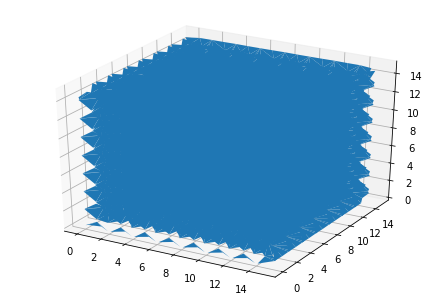

Model saved at _output/3d-vae-gan/model/epoch_520/model.ckpt
###########
Epoch 520 Completed
Elapsed Time: 245.58309286038082 mins
Epoch 521 Start
	Batch=0
Epoch 521 Completed
Elapsed Time: 246.03357329765956 mins
Epoch 522 Start
	Batch=0
Epoch 522 Completed
Elapsed Time: 246.49253474473954 mins
Epoch 523 Start
	Batch=0
Epoch 523 Completed
Elapsed Time: 246.94551074107488 mins
Epoch 524 Start
	Batch=0
Epoch 524 Completed
Elapsed Time: 247.39898849725722 mins
Epoch 525 Start
	Batch=0
Epoch 525 Completed
Elapsed Time: 247.84976377487183 mins
Epoch 526 Start
	Batch=0
Epoch 526 Completed
Elapsed Time: 248.30370407104493 mins
Epoch 527 Start
	Batch=0
Epoch 527 Completed
Elapsed Time: 248.76154600381852 mins
Epoch 528 Start
	Batch=0
Epoch 528 Completed
Elapsed Time: 249.21453206141788 mins
Epoch 529 Start
	Batch=0
Epoch 529 Completed
Elapsed Time: 249.67227176030477 mins
Epoch 530 Start
	Batch=0
###########
epoch:
D Loss: 0.04542506
G Loss: 0.046183243
VAE loss: 4256.662
KL divergence: 851.2

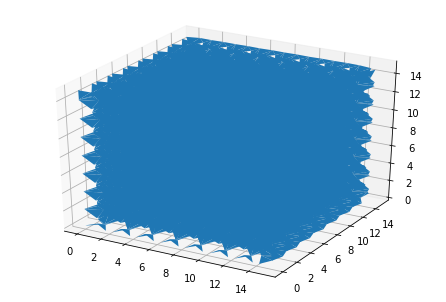

Model saved at _output/3d-vae-gan/model/epoch_530/model.ckpt
###########
Epoch 530 Completed
Elapsed Time: 250.33485023975373 mins
Epoch 531 Start
	Batch=0
Epoch 531 Completed
Elapsed Time: 250.78220252195993 mins
Epoch 532 Start
	Batch=0


KeyboardInterrupt: 

In [7]:
# open session and initialize all variables
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    logger = tf.summary.FileWriter(graphs_dir, sess.graph)
    merged = tf.summary.merge_all()

    saver = tf.train.Saver()

    # training-loop
    start = time.time()
    num_epochs = 100
    save_every = 10
    batch_size = 1
    print('Start Training')
    print('\tnum_epochs = ', num_epochs)
    print('\tbatch_size = ', batch_size)
    print('\tsave_every = ', save_every)

    for epoch in range(20000):
        #x_im, x_3d = dataset.get_batch(batch_size)

        print('Epoch {} Start'.format(epoch))

        for batch_num, batch in enumerate(thingi.voxels_batchmaker(batch_size=batch_size)):

            print('\tBatch={}'.format(batch_num))
            #for _ in range(4):
            sess.run(D_optim, feed_dict={x_encoder_in: batch, x_discr_in: batch, keep_prob: 0.8, isTrain: True})
            sess.run(clip)

            loss_d_, loss_g_, _VAE_loss, _KL_divergence, _reconstruction_loss, summary, _, _, _ = \
                sess.run([D_loss, G_loss, VAE_loss, mean_KL, mean_recon, merged, D_optim, G_optim, E_optim],
                         {x_encoder_in: batch, x_discr_in: batch, keep_prob: 0.8, isTrain: True})
            sess.run(clip)  
            
            break
            
        if epoch % save_every == 0:

            print("###########")
            print("epoch:", )
            print("D Loss:", loss_d_)
            print("G Loss:", loss_g_)
            print("VAE loss:", _VAE_loss)
            print("KL divergence:", _KL_divergence)
            print("reconstruction_loss:", _reconstruction_loss)

            try:
                G = sess.run(G_z, feed_dict={x_encoder_in: batch, x_discr_in: batch, keep_prob: 1, isTrain: False})
                dim = G[0].shape[0]
                vox_vectors = np.reshape(G, (dim, dim, dim))

                ckpt_dir = os.path.join(model_dir, 'epoch_{}'.format(epoch))
                os.makedirs(ckpt_dir, exist_ok=True)

                np_path = os.path.join(ckpt_dir, 'epoch_{}.npy'.format(epoch))
                np.save(np_path, G)

                # Use marching cubes to obtain the surface mesh
                verts, faces, normals, values = measure.marching_cubes_lewiner(vox_vectors, 0)
                save_vectors_as_stl(verts[faces], os.path.join(ckpt_dir, 'epoch_{}.stl'.format(epoch)))
                plot_mesh(verts[faces])
            except Exception as exc:
                print('Model generation failed for this epoch')
                print(exc)
                
            ckpt_path = os.path.join(ckpt_dir, 'model.ckpt'.format(epoch))
            saver.save(sess, ckpt_path)
            print('Model saved at {}'.format(ckpt_path))

            print("###########")

        print('Epoch {} Completed'.format(epoch))
        print('Elapsed Time: {} mins'.format((time.time() - start) / 60))

    sess.close()